In [194]:
"""Find the optimal values for the num_topics, no_above, and no_below hyperparameters. Then, 
train separate LDA models on the entire corpus and yearly sub-corpora.

The expected input is a list of preprocessed document tokens; a list of lists of candidate keyphrase
tokens. A id-keyphrase candidate token dictionary is created to form the vocabulary of the corpus
and this dictionary is used to generate a BoW representation of the corpus. Optimization
for the no_below and no_above hyperparameters threshold the frequency of tokens, while optimization
of the num_topic hyperparameter controls the amount of latent topics for the LDA model to learn.

After the LDA models have been trained, pyLDAvis is used to visualize and rank the candidate keyphrases
which characterize each topic. A relevency weight value, λ, control the ranking of keyphrases; λ=0
ranks keyphrases by their lift, whereas λ=1 ranks keyphrases by topic probability. Keyphrases which are
rarer and exclusive to a topic are given a higher lift, but this can be noisy by ranking rare terms which
only appear in a single document highly. λ=0.6 is suggested for ranking candidate keyphrase in a way 
that is most interpretable to humans. 
"""

# Reset the kernel (ipython magic command)
%reset -f

## How to load the preprocessed data

In [196]:
from pathlib import Path
from topic_modeling import TopicModeler


# Load the preprocessed corpus
year_range = range(2006, 2021)
input_dir = str(Path("../data/preprocessed").resolve())
corpus = TopicModeler.load_corpus(year_range, input_dir)

# Create an id-token mapping for the vocabulary
dictionary = TopicModeler.create_dictionary(corpus)
print("Dictionary:\n", dictionary)

# Create the document-token frequency (Bag-of-Words) representation of the corpus
bow_corpus = TopicModeler.create_bow(corpus, dictionary)
print("-"*50, "\n\nBag-of-Words, first 20 tokens in the first document:\n", bow_corpus[0][:20])

2020-07-19 14:32:18,931 : INFO : Loading preprocessed text from C:\Users\Whyve\Projects\auto-keyphrase-extraction-ru\data\preprocessed\2006.pickle
2020-07-19 14:32:18,965 : INFO : Loading preprocessed text from C:\Users\Whyve\Projects\auto-keyphrase-extraction-ru\data\preprocessed\2007.pickle
2020-07-19 14:32:18,995 : INFO : Loading preprocessed text from C:\Users\Whyve\Projects\auto-keyphrase-extraction-ru\data\preprocessed\2008.pickle
2020-07-19 14:32:19,021 : INFO : Loading preprocessed text from C:\Users\Whyve\Projects\auto-keyphrase-extraction-ru\data\preprocessed\2009.pickle
2020-07-19 14:32:19,044 : INFO : Loading preprocessed text from C:\Users\Whyve\Projects\auto-keyphrase-extraction-ru\data\preprocessed\2010.pickle
2020-07-19 14:32:19,072 : INFO : Loading preprocessed text from C:\Users\Whyve\Projects\auto-keyphrase-extraction-ru\data\preprocessed\2011.pickle
2020-07-19 14:32:19,086 : INFO : Loading preprocessed text from C:\Users\Whyve\Projects\auto-keyphrase-extraction-ru\d

Dictionary:
 Dictionary(11562 unique tokens: ['1-е', 'автоматический', 'актер', 'актуализация', 'анализ']...)
-------------------------------------------------- 

Bag-of-Words, first 20 tokens in the first document:
 [(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 2), (9, 2), (10, 2), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1)]


## Optimize the number of latent topics

2020-07-31 12:58:44,901 : INFO : Loading preprocessed text from C:\Users\Whyve\Projects\auto-keyphrase-extraction-ru\data\preprocessed\2000.pickle
2020-07-31 12:58:45,448 : INFO : Loading preprocessed text from C:\Users\Whyve\Projects\auto-keyphrase-extraction-ru\data\preprocessed\2001.pickle
2020-07-31 12:58:45,515 : INFO : Loading preprocessed text from C:\Users\Whyve\Projects\auto-keyphrase-extraction-ru\data\preprocessed\2002.pickle
2020-07-31 12:58:45,566 : INFO : Loading preprocessed text from C:\Users\Whyve\Projects\auto-keyphrase-extraction-ru\data\preprocessed\2003.pickle
2020-07-31 12:58:45,607 : INFO : Loading preprocessed text from C:\Users\Whyve\Projects\auto-keyphrase-extraction-ru\data\preprocessed\2004.pickle
2020-07-31 12:58:45,655 : INFO : Loading preprocessed text from C:\Users\Whyve\Projects\auto-keyphrase-extraction-ru\data\preprocessed\2005.pickle
2020-07-31 12:58:45,687 : INFO : Loading preprocessed text from C:\Users\Whyve\Projects\auto-keyphrase-extraction-ru\d

coherence_umass: [-0.5978722576315457]
coherence_cv: [0.3544666263822389]
perplexity: [-9.295736276104543]


2020-07-31 14:31:00,618 : INFO : num_topics=4


coherence_umass: [-0.5978722576315457, -0.8774762761810744]
coherence_cv: [0.3544666263822389, 0.44609604119652374]
perplexity: [-9.295736276104543, -9.387068319623655]


2020-07-31 14:43:03,259 : INFO : num_topics=5


coherence_umass: [-0.5978722576315457, -0.8774762761810744, -1.9198924381828737]
coherence_cv: [0.3544666263822389, 0.44609604119652374, 0.456159006216982]
perplexity: [-9.295736276104543, -9.387068319623655, -9.495385526029743]


2020-07-31 15:14:36,798 : INFO : num_topics=6


coherence_umass: [-0.5978722576315457, -0.8774762761810744, -1.9198924381828737, -1.6834717036595586]
coherence_cv: [0.3544666263822389, 0.44609604119652374, 0.456159006216982, 0.45611333415158045]
perplexity: [-9.295736276104543, -9.387068319623655, -9.495385526029743, -9.61121332633026]


2020-07-31 15:46:32,736 : INFO : num_topics=7


coherence_umass: [-0.5978722576315457, -0.8774762761810744, -1.9198924381828737, -1.6834717036595586, -1.9783685890911433]
coherence_cv: [0.3544666263822389, 0.44609604119652374, 0.456159006216982, 0.45611333415158045, 0.38232590584191406]
perplexity: [-9.295736276104543, -9.387068319623655, -9.495385526029743, -9.61121332633026, -9.745120605535107]


2020-07-31 16:05:17,784 : INFO : num_topics=8


coherence_umass: [-0.5978722576315457, -0.8774762761810744, -1.9198924381828737, -1.6834717036595586, -1.9783685890911433, -1.9364256326720943]
coherence_cv: [0.3544666263822389, 0.44609604119652374, 0.456159006216982, 0.45611333415158045, 0.38232590584191406, 0.36904073463886417]
perplexity: [-9.295736276104543, -9.387068319623655, -9.495385526029743, -9.61121332633026, -9.745120605535107, -9.910045588242893]


2020-07-31 16:24:33,972 : INFO : num_topics=9


coherence_umass: [-0.5978722576315457, -0.8774762761810744, -1.9198924381828737, -1.6834717036595586, -1.9783685890911433, -1.9364256326720943, -2.0086450319266924]
coherence_cv: [0.3544666263822389, 0.44609604119652374, 0.456159006216982, 0.45611333415158045, 0.38232590584191406, 0.36904073463886417, 0.36095696551498835]
perplexity: [-9.295736276104543, -9.387068319623655, -9.495385526029743, -9.61121332633026, -9.745120605535107, -9.910045588242893, -10.122794406372405]


2020-07-31 16:46:21,833 : INFO : num_topics=10


coherence_umass: [-0.5978722576315457, -0.8774762761810744, -1.9198924381828737, -1.6834717036595586, -1.9783685890911433, -1.9364256326720943, -2.0086450319266924, -2.56828279478065]
coherence_cv: [0.3544666263822389, 0.44609604119652374, 0.456159006216982, 0.45611333415158045, 0.38232590584191406, 0.36904073463886417, 0.36095696551498835, 0.36561638368828026]
perplexity: [-9.295736276104543, -9.387068319623655, -9.495385526029743, -9.61121332633026, -9.745120605535107, -9.910045588242893, -10.122794406372405, -10.389273982424992]


2020-07-31 17:10:01,719 : INFO : num_topics=11


coherence_umass: [-0.5978722576315457, -0.8774762761810744, -1.9198924381828737, -1.6834717036595586, -1.9783685890911433, -1.9364256326720943, -2.0086450319266924, -2.56828279478065, -2.327117406165172]
coherence_cv: [0.3544666263822389, 0.44609604119652374, 0.456159006216982, 0.45611333415158045, 0.38232590584191406, 0.36904073463886417, 0.36095696551498835, 0.36561638368828026, 0.3627549930015723]
perplexity: [-9.295736276104543, -9.387068319623655, -9.495385526029743, -9.61121332633026, -9.745120605535107, -9.910045588242893, -10.122794406372405, -10.389273982424992, -10.876372785321566]


2020-07-31 17:35:51,135 : INFO : num_topics=12


coherence_umass: [-0.5978722576315457, -0.8774762761810744, -1.9198924381828737, -1.6834717036595586, -1.9783685890911433, -1.9364256326720943, -2.0086450319266924, -2.56828279478065, -2.327117406165172, -1.400122510356188]
coherence_cv: [0.3544666263822389, 0.44609604119652374, 0.456159006216982, 0.45611333415158045, 0.38232590584191406, 0.36904073463886417, 0.36095696551498835, 0.36561638368828026, 0.3627549930015723, 0.3333095018935674]
perplexity: [-9.295736276104543, -9.387068319623655, -9.495385526029743, -9.61121332633026, -9.745120605535107, -9.910045588242893, -10.122794406372405, -10.389273982424992, -10.876372785321566, -11.612645122684285]


2020-07-31 18:01:21,772 : INFO : num_topics=13


coherence_umass: [-0.5978722576315457, -0.8774762761810744, -1.9198924381828737, -1.6834717036595586, -1.9783685890911433, -1.9364256326720943, -2.0086450319266924, -2.56828279478065, -2.327117406165172, -1.400122510356188, -0.7921369145876711]
coherence_cv: [0.3544666263822389, 0.44609604119652374, 0.456159006216982, 0.45611333415158045, 0.38232590584191406, 0.36904073463886417, 0.36095696551498835, 0.36561638368828026, 0.3627549930015723, 0.3333095018935674, 0.3378258534240861]
perplexity: [-9.295736276104543, -9.387068319623655, -9.495385526029743, -9.61121332633026, -9.745120605535107, -9.910045588242893, -10.122794406372405, -10.389273982424992, -10.876372785321566, -11.612645122684285, -12.37605843379131]


2020-07-31 18:28:23,481 : INFO : num_topics=14


coherence_umass: [-0.5978722576315457, -0.8774762761810744, -1.9198924381828737, -1.6834717036595586, -1.9783685890911433, -1.9364256326720943, -2.0086450319266924, -2.56828279478065, -2.327117406165172, -1.400122510356188, -0.7921369145876711, -1.0802350873192494]
coherence_cv: [0.3544666263822389, 0.44609604119652374, 0.456159006216982, 0.45611333415158045, 0.38232590584191406, 0.36904073463886417, 0.36095696551498835, 0.36561638368828026, 0.3627549930015723, 0.3333095018935674, 0.3378258534240861, 0.32592087319936963]
perplexity: [-9.295736276104543, -9.387068319623655, -9.495385526029743, -9.61121332633026, -9.745120605535107, -9.910045588242893, -10.122794406372405, -10.389273982424992, -10.876372785321566, -11.612645122684285, -12.37605843379131, -13.708150073020803]


2020-07-31 18:58:15,926 : INFO : num_topics=15


coherence_umass: [-0.5978722576315457, -0.8774762761810744, -1.9198924381828737, -1.6834717036595586, -1.9783685890911433, -1.9364256326720943, -2.0086450319266924, -2.56828279478065, -2.327117406165172, -1.400122510356188, -0.7921369145876711, -1.0802350873192494, -0.6662016457853389]
coherence_cv: [0.3544666263822389, 0.44609604119652374, 0.456159006216982, 0.45611333415158045, 0.38232590584191406, 0.36904073463886417, 0.36095696551498835, 0.36561638368828026, 0.3627549930015723, 0.3333095018935674, 0.3378258534240861, 0.32592087319936963, 0.3297043975331904]
perplexity: [-9.295736276104543, -9.387068319623655, -9.495385526029743, -9.61121332633026, -9.745120605535107, -9.910045588242893, -10.122794406372405, -10.389273982424992, -10.876372785321566, -11.612645122684285, -12.37605843379131, -13.708150073020803, -15.166753565041935]
coherence_umass: [-0.5978722576315457, -0.8774762761810744, -1.9198924381828737, -1.6834717036595586, -1.9783685890911433, -1.9364256326720943, -2.0086450

<Figure size 432x288 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

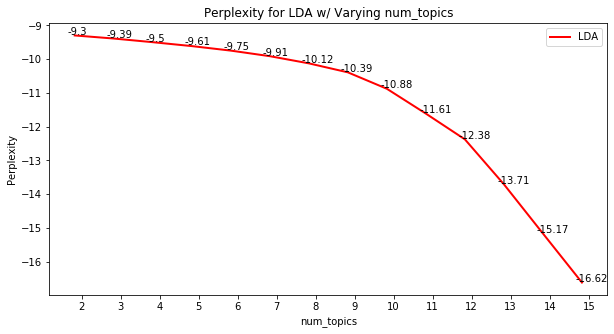

In [12]:
# Note: This will not work through jupyter notebook one Windows due to the multiprocessing
# module used for calculating Cv Coherence. Run these commands in a python shell.

from pathlib import Path
from topic_modeling import optimize_num_topics, TopicModeler


# Parameters
year_range = range(2000, 2021)
input_dir = str(Path("../data/preprocessed").resolve())
target = str(Path("../data/LDA/num_topics").resolve())
repetitions = 3
no_above = .75
no_below = 1
candidate_num_topics = range(2, 16)

corpus = TopicModeler.load_corpus(year_range, input_dir)
dictionary = TopicModeler.create_dictionary(corpus, no_below=no_below, no_above=no_above)
bow_corpus = TopicModeler.create_bow(corpus, dictionary)
optimize_num_topics(candidate_num_topics, corpus, dictionary, bow_corpus, 
                    target, repetitions=repetitions)

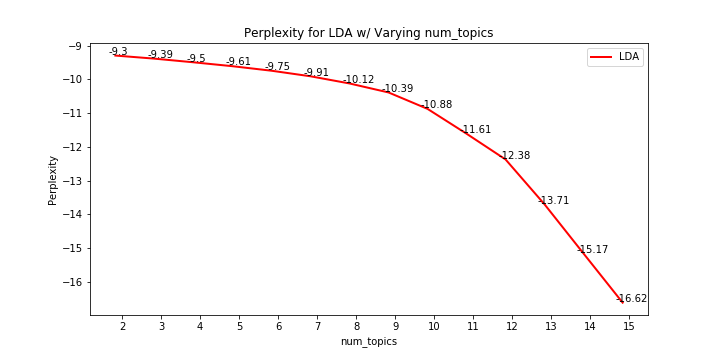

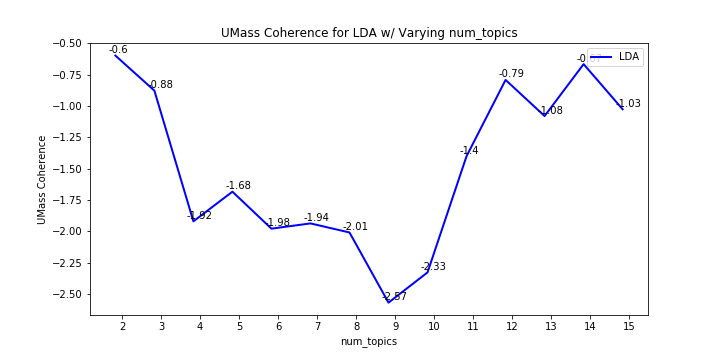

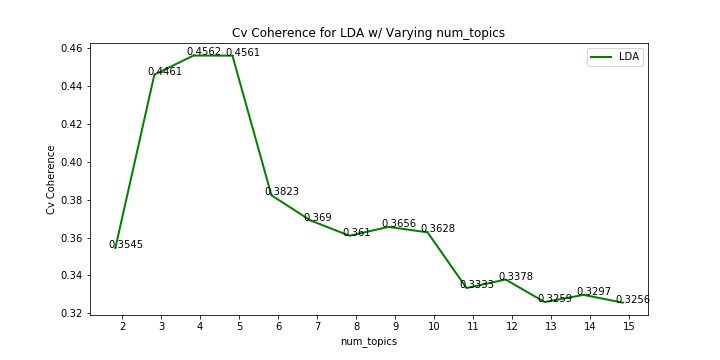

In [1]:
from IPython.display import Image
from pathlib import Path


# Show the results of optimizing num_topics
input_dir = str(Path("../data/LDA/num_topics/").resolve())
display(Image(str(Path(input_dir, "num_topics-perplexity.png"))))
display(Image(str(Path(input_dir, "num_topics-coherence_umass.png"))))
display(Image(str(Path(input_dir, "num_topics-coherence_cv.png"))))

## Optimize no_above

In [ ]:
# Note: This will not work through jupyter notebook one Windows due to the multiprocessing
# module used for calculating Cv Coherence. Run these commands in a python shell.

from pathlib import Path
from topic_modeling import optimize_no_above, TopicModeler


# Parameters
year_range = range(2000, 2021)
input_dir = str(Path("../data/").resolve())
target = str(Path("../data/LDA/no_above").resolve())
repetitions = 3
num_topics = 6
no_below = 2
candidate_no_above= [i/100 for i in range(50, 101, 5)]

corpus = TopicModeler.load_corpus(year_range, input_dir)
optimize_no_above(candidate_no_above, corpus, target,
                  no_below=no_below, repetitions=repetitions, num_topics=num_topics)

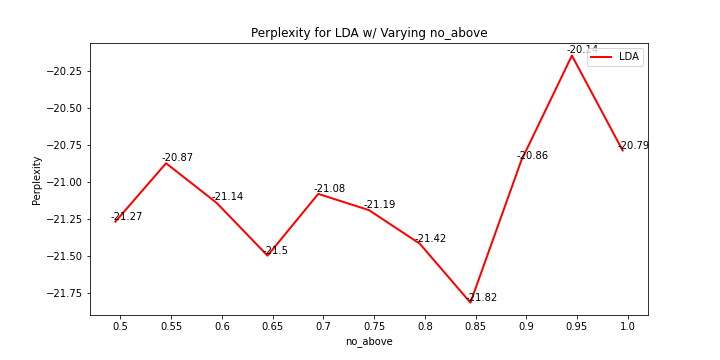

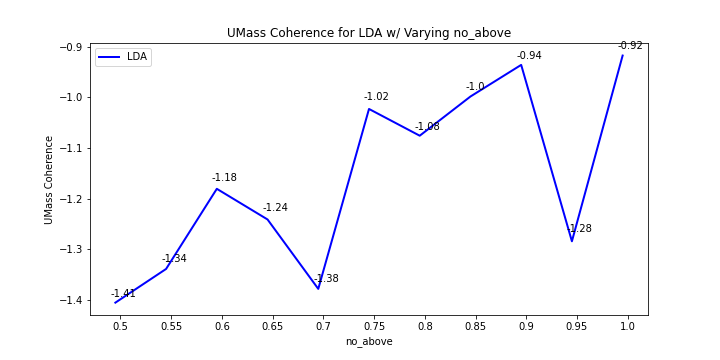

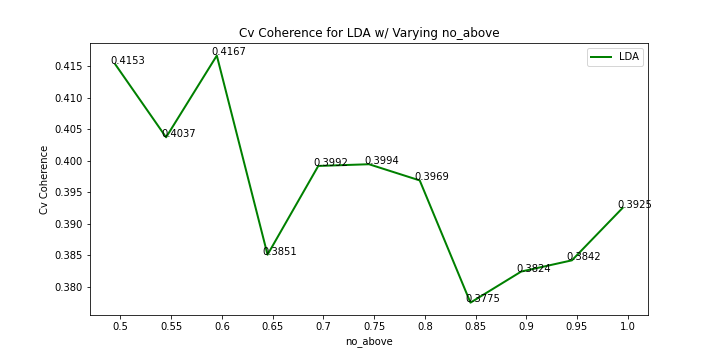

In [3]:
from IPython.display import Image
from pathlib import Path

# Show the results of optimizing no_above
input_dir = str(Path("../data/LDA/no_above/").resolve())
display(Image(str(Path(input_dir, "no_above-perplexity.png"))))
display(Image(str(Path(input_dir, "no_above-coherence_umass.png"))))
display(Image(str(Path(input_dir, "no_above-coherence_cv.png"))))

## Optimize no_below

In [ ]:
# Note: This will not work through jupyter notebook one Windows due to the multiprocessing
# module used for calculating Cv Coherence. Run these commands in a python shell.

from pathlib import Path
from topic_modeling import optimize_no_below, TopicModeler


# Parameters
year_range = range(2000, 2021)
input_dir = str(Path("../data/").resolve())
target = str(Path("../data/LDA/no_below").resolve())
repetitions = 3
num_topics = 6
no_above = .75
candidate_no_below= [i for i in range(1, 11)]

corpus = TopicModeler.load_corpus(year_range, input_dir)
optimize_no_below(candidate_no_below, corpus, target,
                  no_above=no_above, repetitions=repetitions, num_topics=num_topics)

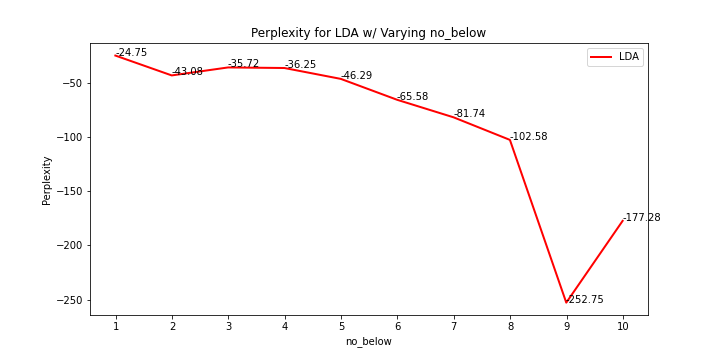

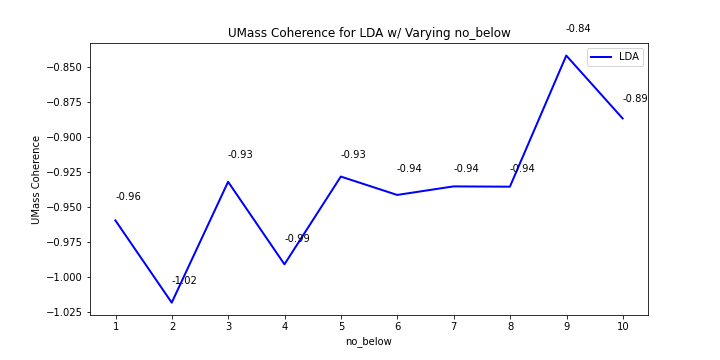

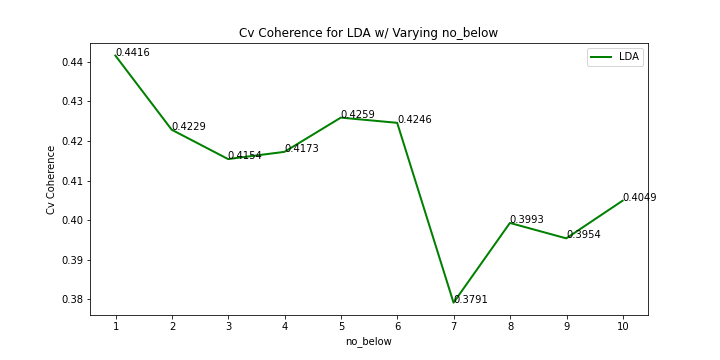

In [2]:
from IPython.display import Image
from pathlib import Path

# Show the results of optimizing no_below
input_dir = str(Path("../data/LDA/no_below/").resolve())
display(Image(str(Path(input_dir, "no_below-perplexity.png"))))
display(Image(str(Path(input_dir, "no_below-coherence_umass.png"))))
display(Image(str(Path(input_dir, "no_below-coherence_cv.png"))))

## Optimize no_above _and_ no_below

In [55]:
from helpers import get_file_names
from pathlib import Path
from topic_modeling import TopicModeler

import logging
import os
import pickle


num_topics = [5]
no_above = [.6, .65, .7, .75, .8]
no_below = [1, 2, 3]

repetitions = 3
target = str(Path("../data/LDA/final/hyperparams").resolve())

if not os.path.exists(target):
    os.makedirs(target)

# Load the preprocessed corpus
year_range = range(2000, 2021)
input_dir = str(Path("../data/preprocessed").resolve())
corpus = []
corpus_keys = []
for year in year_range:
    input_file = Path(input_dir, str(year) + ".pickle")
    with open(input_file, "rb") as file:
        cur_corpus = pickle.load(file)
    for doc_id, doc in enumerate(cur_corpus):
        key = str(year) + "_" + str(doc_id)
        corpus.append(doc)
        corpus_keys.append(key)
    
coherence_umass = []
coherence_cv = []
perplexity = []

for n in num_topics:
    print("-"*100, "\nnumtopics:", n)
    for nb in no_below:
        print("-"*50, "\nno_below:", nb)
        for na in no_above:
            print("-"*25, "\nno_above:", na)
            dictionary = TopicModeler.create_dictionary(corpus, no_below=nb, no_above=na)
            bow_corpus = TopicModeler.create_bow(corpus, dictionary)

            # Get the best model of some repetitions
            best_coherence = -1
            for i in range(repetitions):
                print("Repetition[{}/{}]".format(i+1, repetitions), end=" ")
                lda_model = TopicModeler.train_lda(bow_corpus, dictionary, num_topics=n)
                cur_coherence = TopicModeler.get_coherence_cv(lda_model, corpus, dictionary)
                if (cur_coherence > best_coherence):
                    best_coherence = cur_coherence
                    lda_model.save(str(Path(target, "_".join([str(n), str(nb), str(na)]) + ".gensim")))
                print("Coherence = {} (best: {})".format(cur_coherence, best_coherence))

---------------------------------------------------------------------------------------------------- 
numtopics: 5
-------------------------------------------------- 
no_below: 1
------------------------- 
no_above: 0.6
Repetition[1/3] Coherence = 0.42549173290112 (best: 0.42549173290112)
Repetition[2/3] Coherence = 0.39150965425692064 (best: 0.42549173290112)
Repetition[3/3] Coherence = 0.41434198332006894 (best: 0.42549173290112)
------------------------- 
no_above: 0.65
Repetition[1/3] Coherence = 0.4580213152503247 (best: 0.4580213152503247)
Repetition[2/3] Coherence = 0.4261903332682431 (best: 0.4580213152503247)
Repetition[3/3] Coherence = 0.4019487042202427 (best: 0.4580213152503247)
------------------------- 
no_above: 0.7
Repetition[1/3] Coherence = 0.4636112971858083 (best: 0.4636112971858083)
Repetition[2/3] Coherence = 0.4184402755330653 (best: 0.4636112971858083)
Repetition[3/3] Coherence = 0.4593189649637579 (best: 0.4636112971858083)
------------------------- 
no_above: 

In [62]:
from helpers import get_file_names
from pathlib import Path
from topic_modeling import TopicModeler

import logging
import os
import pickle
from gensim.models import LdaModel


num_articles = 3
num_words = 7

num_topics = 5
no_above = [.6, .65, .7, .75, .8]
no_below = [1, 2, 3]
target = str(Path("../data/LDA/final/hyperparams").resolve())

# Load the preprocessed corpus
year_range = range(2000, 2021)
input_dir = str(Path("../data/preprocessed").resolve())
corpus = []
corpus_keys = []
for year in year_range:
    input_file = Path(input_dir, str(year) + ".pickle")
    with open(input_file, "rb") as file:
        cur_corpus = pickle.load(file)

    file_names = get_file_names("../data/raw_txt/" + str(year) + "/ru", ".txt")
    file_names = [os.path.split(name)[1][:20] for name in file_names]
    
    for doc_id, doc in enumerate(cur_corpus):
        key = str(year) + "_" + file_names[doc_id]
        corpus.append(doc)
        corpus_keys.append(key)

# Load all models
all_coherence = []
all_perplexity = []

for nb in no_below:
    nb_coherence = []
    nb_perplexity = []
    for na in no_above:
        print("Topics for num_topics={}; no_below={}; no_above={}".format(num_topics, nb, na), end=" ")
        lda_model = LdaModel.load(str(Path(target, "_".join([str(num_topics), str(nb), str(na)]) + ".gensim")))

        dictionary = TopicModeler.create_dictionary(corpus, no_below=nb, no_above=na)
        bow_corpus = TopicModeler.create_bow(corpus, dictionary)
        
        coherence = TopicModeler.get_coherence_cv(lda_model, corpus, dictionary)
        perplexity = TopicModeler.get_perplexity(lda_model, bow_corpus)
        
        nb_perplexity.append(perplexity)
        nb_coherence.append(coherence)

        topic_probs = {i: [] for i in range(num_topics)}
        top_articles = []
        for doc_id, doc in zip(corpus_keys, corpus):
            topic_distribution = lda_model[lda_model.id2word.doc2bow(doc)]
            for topic_id, probability in topic_distribution:
                topic_probs[topic_id].append((doc_id, probability))
        for topic_id, doc_probs in topic_probs.items():
            doc_probs = sorted(doc_probs, key = lambda x: x[1], reverse = True)
            top_articles.append([prob for prob in doc_probs[:num_articles]]) 

        print("(Coherence: {}, Perplexity: {})".format(coherence, perplexity))
        TopicModeler.print_topics(lda_model, num_words=num_words, top_articles=top_articles)
    all_coherence.append(nb_coherence)
    all_perplexity.append(nb_perplexity)

Topics for num_topics=5; no_below=1; no_above=0.6 (Coherence: 0.42549173290112, Perplexity: -9.780783098974908)


,Topic #,Top keywords,Most related articles
0,1,"глаод, лср, нареч, предлог с винута пункт, местинский, обозначение лср, лсп",[2009_квазикорпусное-изуче - 39.59]
1,2,"разметка, проводить, количество, метод, оценка, фрагмент, решение","[2010_обучение-классификат - 91.76], [2000_вариант-системы-расп - 91.55], [2006_фонетико-акустическа - 91.25]"
2,3,"сольный, чилийский, значимый отрывок, основа с исход, декада, овна, конечный гласная","[2000_автоматический-морфо - 20.56], [2003_несклоняемые-существ - 7.94], [2004_вычисление-значимой- - 2.63]"
3,4,"дискурсивный, вводный, отрицание, реплика, собеседник, встречаться, фраза","[2014_vchera-nasochinyalsy - 84.44], [2019_some-features-of-the - 82.49], [2017_tensed-and-non-tense - 80.31]"
4,5,"семантический, выражать, статья, класс, синтаксический, семантика, единица","[2000_бьют-ли-часы-и-фонта - 87.19], [2000_структура-составляющ - 86.40], [2001_типы-конструкций-со- - 84.75]"


Topics for num_topics=5; no_below=1; no_above=0.65 (Coherence: 0.4580213152503247, Perplexity: -9.679487966425043)


,Topic #,Top keywords,Most related articles
0,1,"пауза, диктор, просодический, незавершенность, акцент, интонационный, фонетический","[2008_интоколонатор-компью - 48.13], [2006_фонетико-акустическа - 46.14], [2004_персональные-особенн - 42.78]"
1,2,"отрицание, дискурсивный, событие, реплика, собеседник, коммуникация, характерный","[2005_русский-анекдот-в-дв - 73.49], [2019_some-features-of-the - 72.57], [2017_semantic-halo-of-a-m - 72.54]"
2,3,"семантика, выражать, семантический, статья, сочетание, интерпретация, предикат","[2000_бьют-ли-часы-и-фонта - 63.51], [2002_употребление-возврат - 61.30], [2016_видовые-пары-семанти - 59.65]"
3,4,"число, класс, информация, признак, разметка, структура, показывать","[2006_методы-автоматизации - 98.95], [2010_сравнительный-анализ - 98.65], [2005_автоматизация-отладк - 98.48]"
4,5,"запрос, документ, статья, ссылка, веб, пользователь, поиск","[2010_исследование-поисков - 32.18], [2006_подход-к-построению- - 30.65], [2002_организация-порталов - 29.28]"


Topics for num_topics=5; no_below=1; no_above=0.7 (Coherence: 0.4636112971858083, Perplexity: -9.66772855578833)


,Topic #,Top keywords,Most related articles
0,1,"событие, век, тоска, точка зрение, употреблять, характерный, проходить","[2019_some-features-of-the - 74.17], [2014_vchera-nasochinyalsy - 73.76], [2018_building-a-corpus-fo - 68.92]"
1,2,"вводный, отрицание, дискурсивный, отмечать, оказываться, встречаться, параметр","[2017_корпус-кетских-и-эве - 73.84], [2005_датская-интонация-в- - 70.09], [2005_интонация-как-выраже - 69.47]"
2,3,"семантический, признак, класс, выражать, возможный, структура, возможность","[2000_алгоритмы-cегментаци - 95.75], [2000_реализация-первичног - 91.88], [2000_структура-составляющ - 91.05]"
3,4,"глаод, лср, нареч, обозначение лср, предлог с винута пункт, местинский, лсп","[2009_квазикорпусное-изуче - 37.56], [2000_автоматический-морфо - 20.43], [2003_несклоняемые-существ - 2.81]"
4,5,"разметка, метод, задача, поиск, запрос, использование, ресурс","[2000_автоматизация-технич - 66.97], [2000_abbyy-retrieval-morp - 63.21], [2013_классификация-отзыво - 60.09]"


Topics for num_topics=5; no_below=1; no_above=0.75 (Coherence: 0.48376441289386296, Perplexity: -9.603316432014092)


,Topic #,Top keywords,Most related articles
0,1,"диктор, пауза, просодический, незавершенность, интонационный, подъем, фонетический","[2008_интоколонатор-компью - 44.66], [2006_фонетико-акустическа - 40.05], [2004_персональные-особенн - 38.56]"
1,2,"запрос, алгоритм, поиск, пользователь, документ, параметр, статья","[2000_abbyy-retrieval-morp - 57.21], [2013_классификация-отзыво - 45.51], [2010_обучение-классификат - 43.21]"
2,3,"выражать, семантический, семантика, отрицание, предикат, сочетание, обозначать","[2000_бьют-ли-часы-и-фонта - 61.03], [2020_видовые-тройки-русск - 54.65], [2003_еще-раз-о-соотношени - 48.88]"
3,4,"качество, число, возможность, признак, информация, описывать, основной","[2002_модели-лингвистическ - 92.52], [2002_введение-в-теорию-по - 92.35], [2003_электронных-корпус-т - 91.60]"
4,5,"вводный, дискурсивный, параметр, статья, оказываться, устный, реплика","[2001_политический-анекдот - 77.63], [2008_мы-или-другие-имитац - 75.89], [2004_анекдоты-о-животных- - 74.15]"


Topics for num_topics=5; no_below=1; no_above=0.8 (Coherence: 0.5437695406633771, Perplexity: -9.535036124679408)


,Topic #,Top keywords,Most related articles
0,1,"глаод, лср, нареч, обозначение лср, предлог с винута пункт, местинский, лсп","[2009_квазикорпусное-изуче - 36.83], [2000_автоматический-морфо - 19.32]"
1,2,"значение, пример, выражать, отрицание, семантика, событие, вводный","[2014_vchera-nasochinyalsy - 91.24], [2005_русский-анекдот-в-дв - 86.05], [2016_information-retrieva - 85.10]"
2,3,"пауза, диктор, просодический, строка, незавершенность, запись, акцент","[2008_интоколонатор-компью - 46.64], [2006_фонетико-акустическа - 44.43], [2009_просодическая-транск - 43.05]"
3,4,"тип, пример, значение, результат, семантический, признак, класс","[2000_структура-составляющ - 90.28], [2012_союзы-коннекторы-и-т - 88.58], [2005_окрестностные-грамма - 86.87]"
4,5,"разметка, результат, метод, задача, поиск, запрос, алгоритм","[2000_abbyy-retrieval-morp - 70.60], [2013_классификация-отзыво - 69.25], [2000_автоматизация-технич - 64.32]"


Topics for num_topics=5; no_below=2; no_above=0.6 (Coherence: 0.3807821803415499, Perplexity: -8.945519657175563)


,Topic #,Top keywords,Most related articles
0,1,"единица, отмечать, дискурсивный, вводный, предполагать, степень, устный","[2006_сопоставительный-ана - 80.23], [2005_интонация-как-выраже - 78.64], [2017_корпус-кетских-и-эве - 77.78]"
1,2,"разметка, признак, количество, правило, проводить, метод, частота","[2002_универсальный-модуль - 84.46], [2015_графовый-подход-в-за - 83.70], [2007_алгоритм-высокоточно - 83.56]"
2,3,"выражать, событие, век, петя, обозначать, тоска, средний","[2014_vchera-nasochinyalsy - 82.58], [2019_some-features-of-the - 79.31], [2018_building-a-corpus-fo - 70.63]"
3,4,"семантический, отрицание, семантика, интерпретация, класс, свойство, предикат","[2000_автоматический-морфо - 68.15], [2003_еще-раз-о-соотношени - 58.43], [2003_проблемы-автоматичес - 55.65]"
4,5,"оценка, поиск, запрос, параметр, ресурс, создание, база","[2008_портал-знаний-по-ком - 90.04], [2006_подход-к-построению- - 83.44], [2002_организация-порталов - 75.52]"


Topics for num_topics=5; no_below=2; no_above=0.65 (Coherence: 0.40198612578820636, Perplexity: -8.897596359363018)


,Topic #,Top keywords,Most related articles
0,1,"отрицание, клауза, пауза, позиция, диктор, просодический, строка","[2006_фонетико-акустическа - 58.53], [2005_интонация-как-выраже - 57.69], [2004_к-формированию-акуст - 56.33]"
1,2,"ресурс, поиск, пользователь, информация, создание, обучение, база","[2000_автоматизация-технич - 67.04], [2006_подход-к-построению- - 60.76], [2008_портал-знаний-по-ком - 57.94]"
2,3,"оказываться, вводный, единица, интерпретация, дискурсивный, отмечать, событие","[2005_логико-психологическ - 75.26], [2006_логико-психологическ - 74.78], [2002_языковая-личность-в- - 71.85]"
3,4,"разметка, признак, число, класс, оценка, структура, правило","[2010_сравнительный-анализ - 94.17], [2010_об-одном-статистичес - 92.43], [2006_методы-автоматизации - 92.12]"
4,5,"выражать, семантический, сочетание, семантика, действие, обозначать, валентность","[2014_vchera-nasochinyalsy - 73.92], [2019_some-features-of-the - 71.81], [2001_лексика-со-значением - 70.98]"


Topics for num_topics=5; no_below=2; no_above=0.7 (Coherence: 0.4621493122243008, Perplexity: -8.860019699004559)


,Topic #,Top keywords,Most related articles
0,1,"признак, структура, оценка, класс, описание, определять, элемент","[2002_введение-в-теорию-по - 81.09], [2002_знак-в-неформальной- - 77.86], [2008_предметная-онтология - 72.73]"
1,2,"выражать, дискурсивный, статья, устный, реплика, собеседник, коммуникация","[2017_semantic-halo-of-a-m - 83.79], [2014_vchera-nasochinyalsy - 81.01], [2018_building-a-corpus-fo - 78.74]"
2,3,"пауза, запись, строка, диктор, просодический, испытуемый, акцент","[2008_интоколонатор-компью - 54.59], [2006_фонетико-акустическа - 53.95], [2005_реализация-межязыков - 50.73]"
3,4,"отрицание, семантика, семантический, вводный, синтаксический, указывать, встречаться","[2003_еще-раз-о-соотношени - 66.55], [2002_употребление-возврат - 66.01], [2007_идентификация-поссес - 61.94]"
4,5,"разметка, метод, задача, поиск, использование, число, проводить","[2009_подход-к-созданию-мн - 82.42], [2000_abbyy-retrieval-morp - 80.05], [2013_классификация-отзыво - 78.25]"


Topics for num_topics=5; no_below=2; no_above=0.75 (Coherence: 0.48983926642480224, Perplexity: -8.827614515013064)


,Topic #,Top keywords,Most related articles
0,1,"общий, показывать, разный, приводить, единица, число, выражать","[2000_алгоритмы-cегментаци - 86.23], [2006_влияние-объема-опера - 84.44], [2003_тест-по-определению- - 84.03]"
1,2,"пауза, запись, диктор, просодический, строка, акцент, незавершенность","[2008_интоколонатор-компью - 52.72], [2006_фонетико-акустическа - 51.12], [2007_алгоритмы-синтеза-пр - 48.80]"
2,3,"разметка, метод, задача, поиск, информация, запрос, база","[2000_автоматизация-технич - 76.05], [2000_abbyy-retrieval-morp - 74.99], [2000_semp-l-программная-с - 73.09]"
3,4,"век, реплика, собеседник, дискурсивный, событие, акт, адресат","[2019_some-features-of-the - 75.70], [2014_vchera-nasochinyalsy - 75.23], [2017_semantic-halo-of-a-m - 74.21]"
4,5,"семантический, семантика, отрицание, класс, предикат, сочетание, обозначать","[2015_глаголы-быть-и-быват - 59.74], [2013_неотрицаемые-предика - 57.53], [2003_еще-раз-о-соотношени - 55.84]"


Topics for num_topics=5; no_below=2; no_above=0.8 (Coherence: 0.4377243487847136, Perplexity: -8.767952477410017)


,Topic #,Top keywords,Most related articles
0,1,"тип, результат, пример, класс, признак, число, показывать","[2000_алгоритмы-cегментаци - 92.78], [2009_модели-и-методы-учет - 89.55], [2002_универсальный-модуль - 89.14]"
1,2,"отрицание, вводный, событие, дискурсивный, век, встречаться, пример","[2019_some-features-of-the - 78.12], [2014_vchera-nasochinyalsy - 77.54], [2016_information-retrieva - 75.63]"
2,3,"значение, пример, выражать, семантический, тип, семантика, действие","[2000_бьют-ли-часы-и-фонта - 73.73], [2005_об-одном-способе-уст - 56.23], [2006_наблюдатель-типологи - 47.97]"
3,4,"метод, результат, разметка, задача, поиск, запрос, информация","[2008_портал-знаний-по-ком - 81.19], [2002_on-line-интерфейс-на - 71.92], [2006_подход-к-построению- - 71.19]"
4,5,"устный, собеседник, коммуникация, реплика, пауза, диктор, просодический","[2002_инструментальный-ана - 55.62], [2008_способы-взаимодейств - 54.39], [2004_персональные-особенн - 54.14]"


Topics for num_topics=5; no_below=3; no_above=0.6 (Coherence: 0.4272347865088407, Perplexity: -8.653560596941764)


,Topic #,Top keywords,Most related articles
0,1,"дискурсивный, устный, реплика, собеседник, коммуникация, дискурс, пауза","[2005_интонация-как-выраже - 63.51], [2008_интонация-незавершён - 62.59], [2002_инструментальный-ана - 62.30]"
1,2,"единица, встречаться, статья, указывать, вариант, отмечать, следовать","[2000_алгоритмы-cегментаци - 77.50], [2009_модели-и-методы-учет - 68.73], [2005_омонимия-и-синонимия - 68.50]"
2,3,"разметка, метод, оценка, признак, поиск, параметр, проводить","[2013_классификация-отзыво - 85.71], [2016_алгоритм-активного-о - 84.28], [2000_abbyy-retrieval-morp - 83.95]"
3,4,"выражать, отрицание, событие, семантика, обозначать, сочетание, действие","[2014_vchera-nasochinyalsy - 72.72], [2019_some-features-of-the - 68.83], [2017_tensed-and-non-tense - 67.87]"
4,5,"семантический, класс, свойство, предикат, интерпретация, семантика, позиция","[2000_структура-составляющ - 53.99], [2000_влияние-принципа-сме - 48.72], [2000_нетрадиционные-значе - 48.30]"


Topics for num_topics=5; no_below=3; no_above=0.65 (Coherence: 0.4065204769053653, Perplexity: -8.597767446328405)


,Topic #,Top keywords,Most related articles
0,1,"устный, собеседник, пауза, строка, реплика, диктор, просодический","[2008_интоколонатор-компью - 58.25], [2015_к-проблеме-сопостави - 58.08], [2004_персональные-особенн - 56.68]"
1,2,"отрицание, сочетание, предикат, интерпретация, событие, дискурсивный, различие","[2000_автоматический-морфо - 65.06], [2002_употребление-возврат - 55.93], [2003_еще-раз-о-соотношени - 54.04]"
2,3,"семантический, класс, структура, единица, показывать, встречаться, признак","[2000_аннотированный-корпу - 81.39], [2006_рекурсивность-и-прое - 81.36], [2005_окрестностные-грамма - 80.04]"
3,4,"выражать, действие, семантика, тоска, адресат, движение, коммуникация","[2014_vchera-nasochinyalsy - 78.65], [2017_semantic-halo-of-a-m - 76.88], [2016_information-retrieva - 74.93]"
4,5,"разметка, метод, оценка, использование, поиск, запрос, список","[2013_классификация-отзыво - 77.17], [2016_алгоритм-активного-о - 73.47], [2000_abbyy-retrieval-morp - 73.01]"


Topics for num_topics=5; no_below=3; no_above=0.7 (Coherence: 0.4344978957416319, Perplexity: -8.575758185825974)


,Topic #,Top keywords,Most related articles
0,1,"разметка, число, признак, структура, статья, показывать, правило","[2000_алгоритмы-cегментаци - 98.31], [2009_модели-и-методы-учет - 91.59], [2002_универсальный-модуль - 91.42]"
1,2,"диктор, просодический, акцент, дискурсивный, испытуемый, рема, незавершенность","[2002_инструментальный-ана - 49.77], [2005_интонация-как-выраже - 48.42], [2012_региональные-предпоч - 48.18]"
2,3,"метод, запрос, поиск, ресурс, информация, пользователь, задача","[2008_портал-знаний-по-ком - 60.53], [2002_конвейерное-моделиро - 59.38], [2013_классификация-отзыво - 59.32]"
3,4,"выражать, семантический, семантика, отрицание, сочетание, обозначать, интерпретация","[2000_бьют-ли-часы-и-фонта - 79.27], [2013_неотрицаемые-предика - 67.57], [2006_русские-предикатные- - 65.28]"
4,5,"вводный, событие, указывать, отмечать, собеседник, век, характерный","[2014_vchera-nasochinyalsy - 81.23], [2017_semantic-halo-of-a-m - 78.67], [2001_политический-анекдот - 78.00]"


Topics for num_topics=5; no_below=3; no_above=0.75 (Coherence: 0.39712268497243314, Perplexity: -8.535275924909458)


,Topic #,Top keywords,Most related articles
0,1,"разметка, задача, метод, качество, признак, правило, список","[2016_алгоритм-активного-о - 87.71], [2010_обучение-классификат - 83.22], [2001_лемматизация-слов-ру - 82.82]"
1,2,"семантический, выражать, возможный, семантика, разный, описывать, класс","[2000_восстанавливаемость- - 80.88], [2000_нетривиальная-семант - 80.23], [2000_нетрадиционные-значе - 78.85]"
2,3,"событие, отрицание, проходить, статья, характерный, предположение, тоска","[2014_vchera-nasochinyalsy - 77.23], [2018_building-a-corpus-fo - 76.87], [2019_some-features-of-the - 73.55]"
3,4,"информация, проводить, современный, использование, языковой, возможность, запись","[2000_автоматизация-технич - 58.47], [2019_evolution-of-dialect - 58.34], [2013_multi-functional-web - 57.30]"
4,5,"устный, реплика, параметр, коммуникация, пауза, дискурсивный, строка","[2005_интонация-как-выраже - 63.85], [2000_о-высоте-гласных-в-р - 63.03], [2005_датская-интонация-в- - 62.81]"


Topics for num_topics=5; no_below=3; no_above=0.8 (Coherence: 0.43145381453798154, Perplexity: -8.48000839328959)


,Topic #,Top keywords,Most related articles
0,1,"пример, синтаксический, тип, клауза, пауза, именной, показатель","[2005_интонация-как-выраже - 57.99], [2005_датская-интонация-в- - 55.57], [2004_к-формированию-акуст - 54.79]"
1,2,"результат, статья, качество, параметр, метод, проводить, оценка","[2010_обучение-классификат - 85.16], [2016_алгоритм-активного-о - 84.15], [2013_классификация-отзыво - 82.69]"
2,3,"значение, пример, тип, семантический, выражать, описывать, связывать","[2000_бьют-ли-часы-и-фонта - 86.01], [2004_образуют-ли-артефакт - 80.85], [2000_нетривиальная-семант - 80.29]"
3,4,"разметка, информация, поиск, запрос, создание, позволять, ресурс","[2008_портал-знаний-по-ком - 83.81], [2000_abbyy-retrieval-morp - 73.83], [2000_semp-l-программная-с - 70.65]"
4,5,"пример, отрицание, вводный, встречаться, дискурсивный, оказываться, век","[2014_vchera-nasochinyalsy - 84.96], [2017_tensed-and-non-tense - 84.13], [2005_русский-анекдот-в-дв - 80.32]"


<Figure size 432x288 with 0 Axes>

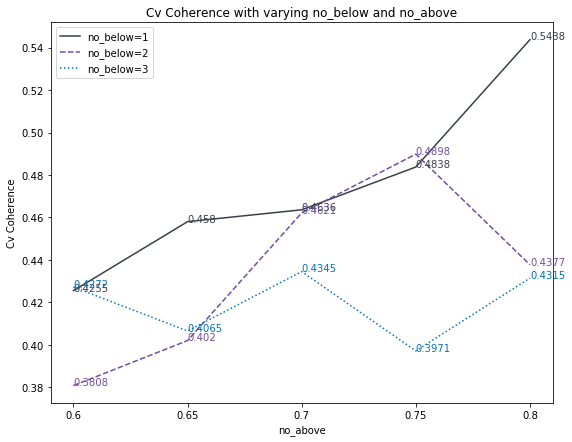

<Figure size 432x288 with 0 Axes>

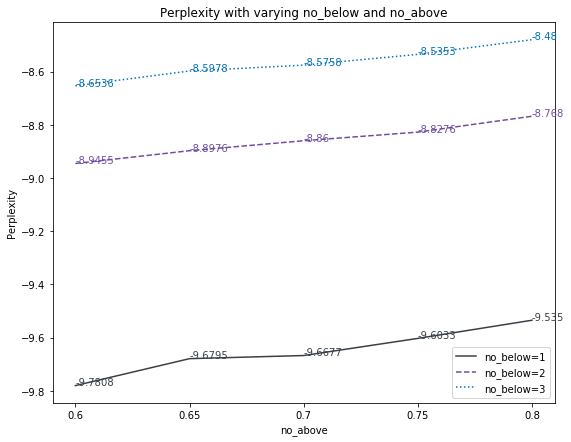

In [63]:
import matplotlib.pyplot as plt
logging.getLogger("matplotlib").setLevel(logging.ERROR)

# Visualize the results

target = str(Path("../data/LDA/final/hyperparams").resolve())
if not os.path.exists(target):
    os.makedirs(target)

no_above = [.6, .65, .7, .75, .8]
no_below = [1, 2, 3]
linewidth = 1.5
xlocs = range(len(no_above))

colors = [(56, 63, 70), (111, 77, 162), (3, 113, 182)]
colors = [(r/255,g/255,b/255) for (r,g,b) in colors]
linestyles = ["solid", "dashed", "dotted"]

plt.clf()
plt.figure(figsize=(9,7))
plt.title("Cv Coherence with varying no_below and no_above")
plt.xlabel("no_above") 
plt.ylabel("Cv Coherence")
for i in range(len(no_below)):
    vals = all_coherence[i]
    plt.plot([str(na) for na in no_above], vals, linewidth=linewidth, label="no_below="+str(no_below[i]), 
             color=colors[i], linestyle=linestyles[i])
    for x, y in enumerate([round(c, 4) for c in vals]):
        plt.text(str(no_above[x]), y, str(y),color=colors[i]) 
        
plt.legend(loc="best")
plt.savefig(Path(target,"no-above_no-below_coherence"))
plt.show()


plt.clf()
plt.figure(figsize=(9,7))
plt.title("Perplexity with varying no_below and no_above")
plt.xlabel("no_above") 
plt.ylabel("Perplexity")
for i in range(len(no_below)):
    vals = all_perplexity[i]
    plt.plot([str(na) for na in no_above], vals, linewidth=linewidth, label="no_below="+str(no_below[i]), 
             color=colors[i], linestyle=linestyles[i])
    for x, y in enumerate([round(c, 4) for c in vals]):
        plt.text(str(no_above[x]), y, str(y),color=colors[i]) 
        
plt.legend(loc="best")
plt.savefig(Path(target,"no-above_no-below_perplexity"))
plt.show()

In [64]:
num_articles = 4
num_words = 7

target = str(Path("../data/LDA/final/hyperparams").resolve())
if not os.path.exists(target):
    os.makedirs(target)

# Load the preprocessed corpus
year_range = range(2000, 2021)
input_dir = str(Path("../data/preprocessed").resolve())
corpus = []
corpus_keys = []
for year in year_range:
    input_file = Path(input_dir, str(year) + ".pickle")
    with open(input_file, "rb") as file:
        cur_corpus = pickle.load(file)

    file_names = get_file_names("../data/raw_txt/" + str(year) + "/ru", ".txt")
    file_names = [os.path.split(name)[1][:20] for name in file_names]
    
    for doc_id, doc in enumerate(cur_corpus):
        key = str(year) + "_" + file_names[doc_id]
        corpus.append(doc)
        corpus_keys.append(key)
    
# Load the best of each no_below and visualize with pyLDAvis
models = [(5, 1, .8), (5, 2, .75), (5, 3, .7)]
for model in models:
    print("Topics for num_topics={}; no_below={}; no_above={}".format(model[0], model[1], model[2]), end=" ")
    lda_model = LdaModel.load(str(Path(target, "_".join([str(model[0]), str(model[1]), str(model[2])]) + ".gensim")))

    dictionary = TopicModeler.create_dictionary(corpus, no_below=model[1], no_above=model[2])
    bow_corpus = TopicModeler.create_bow(corpus, dictionary)
    
    topic_probs = {i: [] for i in range(model[0])}
    top_articles = []
    for doc_id, doc in zip(corpus_keys, corpus):
        topic_distribution = lda_model[lda_model.id2word.doc2bow(doc)]
        for topic_id, probability in topic_distribution:
            topic_probs[topic_id].append((doc_id, probability))
    for topic_id, doc_probs in topic_probs.items():
        doc_probs = sorted(doc_probs, key = lambda x: x[1], reverse = True)
        top_articles.append([prob for prob in doc_probs[:num_articles]]) 
        
    TopicModeler.print_topics(lda_model, num_words=num_words, top_articles=top_articles)
    
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary, sort_topics=False)
    pyLDAvis.save_html(vis, str(Path(target, "_".join([str(model[0]), str(model[1]), str(model[2])]) + ".html")))
    print("-"*50, "\nVisualization for topics:")
    display(pyLDAvis.display(vis))

Topics for num_topics=5; no_below=1; no_above=0.8 

,Topic #,Top keywords,Most related articles
0,1,"глаод, лср, нареч, обозначение лср, предлог с винута пункт, местинский, лсп","[2009_квазикорпусное-изуче - 36.83], [2000_автоматический-морфо - 19.32]"
1,2,"значение, пример, выражать, отрицание, семантика, событие, вводный","[2014_vchera-nasochinyalsy - 91.24], [2005_русский-анекдот-в-дв - 86.05], [2016_information-retrieva - 85.10], [2019_some-features-of-the - 84.82]"
2,3,"пауза, диктор, просодический, строка, незавершенность, запись, акцент","[2008_интоколонатор-компью - 46.64], [2006_фонетико-акустическа - 44.43], [2009_просодическая-транск - 43.05], [2004_персональные-особенн - 41.21]"
3,4,"тип, пример, значение, результат, семантический, признак, класс","[2000_структура-составляющ - 90.28], [2012_союзы-коннекторы-и-т - 88.58], [2005_окрестностные-грамма - 86.87], [2001_об-электронном-слова - 86.03]"
4,5,"разметка, результат, метод, задача, поиск, запрос, алгоритм","[2000_abbyy-retrieval-morp - 70.60], [2013_классификация-отзыво - 69.25], [2000_автоматизация-технич - 64.32], [2002_on-line-интерфейс-на - 62.02]"


c:\users\whyve\appdata\local\programs\python\python37\lib\site-packages\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
c:\users\whyve\appdata\local\programs\python\python37\lib\site-packages\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


-------------------------------------------------- 
Visualization for topics:


Topics for num_topics=5; no_below=2; no_above=0.75 

,Topic #,Top keywords,Most related articles
0,1,"общий, показывать, разный, приводить, единица, число, выражать","[2000_алгоритмы-cегментаци - 86.23], [2006_влияние-объема-опера - 84.44], [2003_тест-по-определению- - 84.03], [2007_разрешение-синтаксич - 83.84]"
1,2,"пауза, запись, диктор, просодический, строка, акцент, незавершенность","[2008_интоколонатор-компью - 52.72], [2006_фонетико-акустическа - 51.12], [2007_алгоритмы-синтеза-пр - 48.80], [2005_интонация-как-выраже - 48.64]"
2,3,"разметка, метод, задача, поиск, информация, запрос, база","[2000_автоматизация-технич - 76.05], [2000_abbyy-retrieval-morp - 74.99], [2000_semp-l-программная-с - 73.09], [2008_портал-знаний-по-ком - 71.03]"
3,4,"век, реплика, собеседник, дискурсивный, событие, акт, адресат","[2019_some-features-of-the - 75.70], [2014_vchera-nasochinyalsy - 75.23], [2017_semantic-halo-of-a-m - 74.21], [2018_building-a-corpus-fo - 67.83]"
4,5,"семантический, семантика, отрицание, класс, предикат, сочетание, обозначать","[2015_глаголы-быть-и-быват - 59.74], [2013_неотрицаемые-предика - 57.53], [2003_еще-раз-о-соотношени - 55.84], [2018_снятая-утвердительно - 55.20]"


-------------------------------------------------- 
Visualization for topics:


Topics for num_topics=5; no_below=3; no_above=0.7 

,Topic #,Top keywords,Most related articles
0,1,"разметка, число, признак, структура, статья, показывать, правило","[2000_алгоритмы-cегментаци - 98.31], [2009_модели-и-методы-учет - 91.59], [2002_универсальный-модуль - 91.42], [2005_модуль-фрагментарног - 91.33]"
1,2,"диктор, просодический, акцент, дискурсивный, испытуемый, рема, незавершенность","[2002_инструментальный-ана - 49.77], [2005_интонация-как-выраже - 48.42], [2012_региональные-предпоч - 48.18], [2006_фонетико-акустическа - 46.77]"
2,3,"метод, запрос, поиск, ресурс, информация, пользователь, задача","[2008_портал-знаний-по-ком - 60.53], [2002_конвейерное-моделиро - 59.38], [2013_классификация-отзыво - 59.32], [2006_построение-модели-зн - 56.81]"
3,4,"выражать, семантический, семантика, отрицание, сочетание, обозначать, интерпретация","[2000_бьют-ли-часы-и-фонта - 79.27], [2013_неотрицаемые-предика - 67.57], [2006_русские-предикатные- - 65.28], [2003_еще-раз-о-соотношени - 65.01]"
4,5,"вводный, событие, указывать, отмечать, собеседник, век, характерный","[2014_vchera-nasochinyalsy - 81.23], [2017_semantic-halo-of-a-m - 78.67], [2001_политический-анекдот - 78.00], [2005_русский-анекдот-в-дв - 76.15]"


-------------------------------------------------- 
Visualization for topics:


## Run LDA and pyLDAvis with the optimized parameters on a single corpus

In [5]:
from helpers import get_file_names
from pathlib import Path
from topic_modeling import TopicModeler

import logging
import os
import pickle

num_topics = 5
no_above = .75
no_below = 2

repetitions = 3

target = str(Path("../data/LDA/final").resolve())
if not os.path.exists(target):
    os.makedirs(target)

# Load the preprocessed corpus
year_range = range(2000, 2021)
input_dir = str(Path("../data/preprocessed").resolve())
corpus = []
corpus_keys = []
for year in year_range:
    input_file = Path(input_dir, str(year) + ".pickle")
    with open(input_file, "rb") as file:
        cur_corpus = pickle.load(file)
        
    file_names = get_file_names("../data/raw_txt/" + str(year) + "/ru", ".txt")
    file_names = [os.path.split(name)[1][:20] for name in file_names]
    
    for doc_id, doc in enumerate(cur_corpus):
        key = str(year) + "_" + file_names[doc_id]
        corpus.append(doc)
        corpus_keys.append(key)

dictionary = TopicModeler.create_dictionary(corpus, no_below=no_below, no_above=no_above)
bow_corpus = TopicModeler.create_bow(corpus, dictionary)

# Get the best model of some repetitions
best_coherence = -1
for i in range(repetitions):
    print("Repetition[{}/{}]".format(i+1, repetitions), end=" ")
    lda_model = TopicModeler.train_lda(bow_corpus, dictionary, num_topics=num_topics)
    cur_coherence = TopicModeler.get_coherence_cv(lda_model, corpus, dictionary)
    if (cur_coherence > best_coherence):
        best_coherence = cur_coherence
        lda_model.save(str(Path(target, "single.gensim")))
    print("Coherence = {} (best: {})".format(cur_coherence, best_coherence))

Repetition[1/3] Coherence = 0.3601402355935843 (best: 0.3601402355935843)
Repetition[2/3] Coherence = 0.4184896589920018 (best: 0.4184896589920018)
Repetition[3/3] Coherence = 0.3790248407775149 (best: 0.4184896589920018)


In [6]:
num_articles = 5
num_words = 7


from gensim.models import LdaModel
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

# Load the best model
lda_model = LdaModel.load(str(Path(target, "single.gensim")))

topic_probs = {i: [] for i in range(num_topics)}
top_articles = []
for doc_id, doc in zip(corpus_keys, corpus):
    topic_distribution = lda_model[lda_model.id2word.doc2bow(doc)]
    for topic_id, probability in topic_distribution:
        topic_probs[topic_id].append((doc_id, probability))
for topic_id, doc_probs in topic_probs.items():
    doc_probs = sorted(doc_probs, key = lambda x: x[1], reverse = True)
    top_articles.append([prob for prob in doc_probs[:num_articles]]) 

print("-"*50, "\nTopics for a single corpus:")
TopicModeler.print_topics(lda_model, num_words=num_words, top_articles=top_articles)

vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
pyLDAvis.save_json(vis, str(Path("../data/LDA/final", "single.json")))
display(pyLDAvis.display(vis))

-------------------------------------------------- 
Topics for entire dialog corpus:


,Topic #,Top keywords,Most related articles
0,1,"дискурсивный, устный, реплика, функция, коммуникация, вопросительный, акт","[2017_я-скажу-тебе-с-после - 43.81], [2017_интонация-перечислен - 42.77], [2015_к-проблеме-сопостави - 42.27], [2009_просодия-обращений-в - 41.91], [2017_побудительная-реплик - 40.11]"
1,2,"выражать, семантический, семантика, отрицание, событие, действие, обозначать","[2014_vchera-nasochinyalsy - 85.46], [2017_semantic-halo-of-a-m - 82.75], [2008_глаголы-погружения-с - 80.21], [2019_some-features-of-the - 79.24], [2001_обозначение-симптомо - 77.97]"
2,3,"показывать, разный, число, приводить, единица, оценка, общий","[2003_модели-образования-ч - 82.33], [2001_корпусная-репрезента - 80.40], [2003_некоторые-проблемы-с - 80.23], [2009_статистический-анали - 80.06], [2004_к-вопросу-о-числе-па - 79.90]"
3,4,"разметка, запрос, поиск, база, обучение, документ, метод","[2000_автоматизация-технич - 58.48], [2000_abbyy-retrieval-morp - 54.55], [2006_фонетико-акустическа - 48.52], [2013_multi-functional-web - 46.38], [2001_мультимедийная-база- - 46.37]"
4,5,"задача, метод, связь, признак, алгоритм, семантический, класс","[2000_semp-l-программная-с - 89.66], [2001_система-представлени - 76.27], [2004_тезаурусное-представ - 76.06], [2006_подход-к-построению- - 71.35], [2002_модели-лингвистическ - 69.71]"


## Run LDA with the optimized parameters

In [2]:
from helpers import get_file_names
from pathlib import Path
from topic_modeling import TopicModeler
from gensim.models import LdaModel

import logging
import os
import pickle

num_topics = 5
no_above = .75
no_below = 2
repetitions = 3
num_articles = 4
num_words = 7

target = str(Path("../data/LDA/final").resolve())
if not os.path.exists(target):
    os.makedirs(target)

# Load the preprocessed corpus
year_range = range(2000, 2021)
input_dir = str(Path("../data/preprocessed").resolve())
entire_corpus = {}
cur_corpus = {}
for year in year_range:
    input_file = Path(input_dir, str(year) + ".pickle")
    cur_corpus = []
    with open(input_file, "rb") as file:
        cur_corpus = pickle.load(file)
    file_names = get_file_names("../data/raw_txt/" + str(year) + "/ru", ".txt")
    file_names = [os.path.split(name)[1][:20] for name in file_names]
    
    for doc_id, doc in enumerate(cur_corpus):
        key = str(year) + "_" + file_names[doc_id]
        entire_corpus[key] = doc
    
    # Create and save the LDA model for each year
    dictionary = TopicModeler.create_dictionary(cur_corpus, no_below=no_below, no_above=no_above)
    bow_corpus = TopicModeler.create_bow(cur_corpus, dictionary)
    
    # Get the best model of some repetitions
    best_coherence = -1
    for i in range(repetitions):
        print("Repetition [{}/{}] for {}".format(i+1, repetitions, year), end=" ")
        lda_model = TopicModeler.train_lda(bow_corpus, dictionary, num_topics=num_topics)
        cur_coherence = TopicModeler.get_coherence_cv(lda_model, cur_corpus, dictionary)
        if (cur_coherence > best_coherence):
            best_coherence = cur_coherence
            lda_model.save(str(Path(target, str(year)+ ".gensim")))
        print("Coherence = {} (best: {})".format(cur_coherence, best_coherence))
    lda_model = LdaModel.load(str(Path(target, str(year) + ".gensim")))
    
    # Get the num_articles most related articles for each topic
    topic_probs = {i: [] for i in range(num_topics)}
    top_articles = []
    for doc_id, doc in enumerate(cur_corpus):
        key = str(year) + "_" + file_names[doc_id]
        topic_distribution = lda_model[lda_model.id2word.doc2bow(doc)]

        for topic_id, probability in topic_distribution:
            topic_probs[topic_id].append((key, probability))
    for topic_id, doc_probs in topic_probs.items():
        doc_probs = sorted(doc_probs, key = lambda x: x[1], reverse = True)
        top_articles.append([prob for prob in doc_probs[:num_articles]]) 
    
    # Print the learned topics and the top associated keyphrases
    print("Topics for", str(year) + ":")
    TopicModeler.print_topics(lda_model, num_words=num_words, top_articles=top_articles)
    cur_corpus = None

# Get keywords for the entire corpus
dictionary = TopicModeler.create_dictionary(entire_corpus.values(), no_below=no_below, no_above=no_above)
bow_corpus = TopicModeler.create_bow(entire_corpus.values(), dictionary)

# Get the best model of some repetitions
best_coherence = -1
for i in range(repetitions):
    print("Repetition [{}/{}] for entire corpus".format(i+1, repetitions), end=" ")
    lda_model = TopicModeler.train_lda(bow_corpus, dictionary, num_topics=num_topics)
    cur_coherence = TopicModeler.get_coherence_cv(lda_model, entire_corpus.values(), dictionary)
    if (cur_coherence > best_coherence):
        best_coherence = cur_coherence
        lda_model.save(str(Path(target, "all.gensim")))
    print("Coherence = {} (best: {})".format(cur_coherence, best_coherence))
lda_model = LdaModel.load(str(Path(target, "all.gensim")))

topic_probs = {i: [] for i in range(num_topics)}
top_articles = []
for doc_id, doc in entire_corpus.items():
    topic_distribution = lda_model[lda_model.id2word.doc2bow(doc)]
    for topic_id, probability in topic_distribution:
        topic_probs[topic_id].append((doc_id, probability))
for topic_id, doc_probs in topic_probs.items():
    doc_probs = sorted(doc_probs, key = lambda x: x[1], reverse = True)
    top_articles.append([prob for prob in doc_probs[:num_articles]]) 

print("Topics for entire dialog corpus:")
TopicModeler.print_topics(lda_model, num_words=num_words, top_articles=top_articles)

Repetition [1/3] for 2000 Coherence = 0.31809551623579824 (best: 0.31809551623579824)
Repetition [2/3] for 2000 Coherence = 0.3359271314887591 (best: 0.3359271314887591)
Repetition [3/3] for 2000 Coherence = 0.3166292126972662 (best: 0.3359271314887591)
Topics for 2000:


,Topic #,Top keywords,Most related articles
0,1,"связь, связывать, пример, описание, информация, позволять, компонент","[2000_abbyy-retrieval-morp - 82.49], [2000_автоматизация-технич - 79.02], [2000_о-высоте-гласных-в-р - 77.83], [2000_закономерности-постр - 75.97]"
1,2,"действие, общение, средний, указательный, синоним, идиома, край","[2000_клишированные-формул - 50.02], [2000_digitall-writing-e-s - 49.98], [2000_речевые-формулы-в-ди - 40.55], [2000_наречия-группы-сразу - 39.97]"
2,3,"правило, понятие, основа, структура, возможность, процесс, определять","[2000_semp-l-программная-с - 90.91], [2000_автоматическая-систе - 84.28], [2000_о-представлении-сема - 82.50], [2000_лингвистические-обол - 64.77]"
3,4,"узел, граница, синтаксический, символ, сокращение, статья, число","[2000_алгоритмы-cегментаци - 97.62], [2000_вариант-системы-расп - 80.99], [2000_аннотированный-корпу - 69.54], [2000_реализация-первичног - 62.71]"
4,5,"значение, семантический, категория, тип, валентность, предмет, обозначать","[2000_нетрадиционные-значе - 66.02], [2000_восстанавливаемость- - 65.24], [2000_одна-категория-или-д - 64.83], [2000_бьют-ли-часы-и-фонта - 62.90]"


Repetition [1/3] for 2001 Coherence = 0.33823929134795677 (best: 0.33823929134795677)
Repetition [2/3] for 2001 Coherence = 0.3422771037561546 (best: 0.3422771037561546)
Repetition [3/3] for 2001 Coherence = 0.33430595187255624 (best: 0.3422771037561546)
Topics for 2001:


,Topic #,Top keywords,Most related articles
0,1,"документ, поиск, алгоритм, информация, основа, метод, пользователь","[2001_система-речевой-связ - 78.33], [2001_лемматизация-слов-ру - 77.70], [2001_об-одном-подходе-к-с - 72.70], [2001_синтезатор-речи-по-т - 69.58]"
1,2,"вербальный, адресат, устный, разный, невербальный, знак, спонтанный","[2001_анализ-аргументативн - 58.48], [2001_к-построению-модели- - 48.50], [2001_интерпретация-устног - 45.45], [2001_лингвистическое-обес - 44.41]"
2,3,"тезаурус, идиома, таксон, страх, пространство, попадать, эмоция","[2001_деривационный-подход - 96.85], [2001_метафорические-модел - 96.85], [2001_проблема-репрезентат - 71.53], [2001_отражение-неоднородн - 71.53]"
3,4,"значение, тип, разный, обозначать, семантический, действие, указывать","[2001_семантика-и-прагмати - 81.91], [2001_типы-видовой-связи.t - 76.00], [2001_о-влиянии-типов-видо - 75.19], [2001_риск-благородное-дел - 73.51]"
4,5,"понятие, описание, знание, тип, структура, использование, рассматривать","[2001_inbase-технология-по - 97.42], [2001_система-представлени - 86.28], [2001_об-электронном-слова - 84.22], [2001_визуализация-смысла- - 80.30]"


Repetition [1/3] for 2002 Coherence = 0.3569980472969706 (best: 0.3569980472969706)
Repetition [2/3] for 2002 Coherence = 0.37220507205147196 (best: 0.37220507205147196)
Repetition [3/3] for 2002 Coherence = 0.36371880196870465 (best: 0.37220507205147196)
Topics for 2002:


,Topic #,Top keywords,Most related articles
0,1,"документ, информация, задача, основа, позволять, тип, структура","[2002_автоматический-орфог - 96.30], [2002_автоматическое-попол - 88.02], [2002_об-автоматизации-сос - 82.91], [2002_синтезатор-татарской - 81.65]"
1,2,"понятие, знание, область, вербальный, графический, онтология, процесс","[2002_on-the-interactive-e - 85.80], [2002_построение-расширени - 85.80], [2002_семантический-поиск- - 76.71], [2002_введение-в-теорию-по - 74.97]"
2,3,"общение, жанр, лингвистический, особенность, научный, стиль, острый","[2002_генерация-содержания - 54.72], [2002_о-принципах-построен - 54.72], [2002_боль-и-части-человеч - 52.94], [2002_автоматическое-опред - 50.43]"
3,4,"поведение, коммуникация, сознание, радость, собеседник, языковой, подобный","[2002_анекдоты-об-армянско - 72.70], [2002_достоинство-гордость - 61.92], [2002_каждая-несчастливая- - 56.91], [2002_есть-ли-орган-для-ше - 54.93]"
4,5,"значение, описывать, синтаксический, действие, интернет, выделять, указывать","[2002_аналитические-констр - 99.07], [2002_дискурсивный-маркер- - 76.60], [2002_к-понятию-симметричн - 70.41], [2002_существительные-со-з - 63.95]"


Repetition [1/3] for 2003 Coherence = 0.37204098030644417 (best: 0.37204098030644417)
Repetition [2/3] for 2003 Coherence = 0.3895153425861232 (best: 0.3895153425861232)
Repetition [3/3] for 2003 Coherence = 0.35687816019985175 (best: 0.3895153425861232)
Topics for 2003:


,Topic #,Top keywords,Most related articles
0,1,"информация, документ, запрос, поиск, пользователь, тезаурус, компьютер","[2003_алгоритм-формировани - 86.64], [2003_адаптивный-лингвисти - 64.14], [2003_интернетинтранет-сис - 51.58], [2003_составляющие-интелле - 41.89]"
1,2,"значение, событие, действие, предикат, семантика, семантический, различать","[2003_глаголы-перемещения- - 52.76], [2003_внутренняя-форма-иди - 52.44], [2003_большие-проблемы-мал - 50.19], [2003_глагольные-времена-в - 49.27]"
2,3,"правило, структура, описание, задача, определять, основа, описывать","[2003_алгоритмы-сегментаци - 96.08], [2003_автоматический-перев - 91.38], [2003_ddc-программа-поиска - 87.09], [2003_автоматизация-процес - 84.67]"
3,4,"понимание, знание, тип, основа, действие, цель, иной","[2003_what-communists-know - 95.61], [2003_актуальные-значения- - 74.79], [2003_когнитивные-модели-и - 73.20], [2003_универсальные-потреб - 69.51]"
4,5,"анекдот, значение, испытуемый, называть, связывать, тип, разный","[2003_полосатые-васьки-и-з - 65.55], [2003_дни-недели-в-различн - 49.94], [2003_еще-раз-о-лексикогра - 42.87], [2003_еще-раз-о-соотношени - 37.77]"


Repetition [1/3] for 2004 Coherence = 0.3406989303963026 (best: 0.3406989303963026)
Repetition [2/3] for 2004 Coherence = 0.3146728109818637 (best: 0.3406989303963026)
Repetition [3/3] for 2004 Coherence = 0.33730994375033185 (best: 0.3406989303963026)
Topics for 2004:


,Topic #,Top keywords,Most related articles
0,1,"цель, событие, стратегия, представление, английский, письменный, дизъюнкция","[2004_коммуникативные-акты - 57.11], [2004_аспекты-моделировани - 44.00], [2004_автоматическая-генер - 39.57], [2004_текстовые-функции-на - 37.86]"
1,2,"значение, вовремя, отрицание, резко, предикат, действие, толкование","[2004_6-способов-косвенног - 86.27], [2004_об-общих-значениях-г - 67.56], [2004_эффект-снятой-утверд - 63.94], [2004_корпус-параллельных- - 59.29]"
2,3,"информация, позволять, задача, основа, использование, структура, возможность","[2004_авиаонтология-анализ - 96.05], [2004_к-вопросу-о-создании - 95.43], [2004_некоторые-подходы-к- - 95.28], [2004_тезаурусное-представ - 94.68]"
3,4,"значение, класс, семантический, сравнение, синтаксический, подобный, падеж","[2004_анекдоты-о-животных- - 71.08], [2004_двойной-генитив-в-ру - 69.88], [2004_проблема-номинации-п - 61.17], [2004_к-проблеме-описания- - 56.90]"
4,5,"окончание, спам, мнута ч, письмо, сообщение, категория, фонетический","[2004_персональные-особенн - 53.34], [2004_рубрикатор-в-борьбе- - 52.02], [2004_к-формированию-акуст - 48.36], [2004_yandex-как-лексикогр - 45.32]"


Repetition [1/3] for 2005 Coherence = 0.37651527988168587 (best: 0.37651527988168587)
Repetition [2/3] for 2005 Coherence = 0.3562380439833115 (best: 0.37651527988168587)
Repetition [3/3] for 2005 Coherence = 0.3780411515935322 (best: 0.3780411515935322)
Topics for 2005:


,Topic #,Top keywords,Most related articles
0,1,"разный, семантический, указывать, синтаксический, выражать, оказываться, фраза","[2005_автоматический-анали - 82.40], [2005_максимум-и-минимум-ч - 79.28], [2005_зоны-синкретизма-в-л - 77.55], [2005_пассив-на-ся-в-русск - 77.37]"
1,2,"предлог, предикат, анекдот, валентность, интерпретация, все-таки, бывший","[2005_омонимия-и-синонимия - 47.15], [2005_об-одном-способе-уст - 38.24], [2005_коррекция-сбоев-в-ус - 37.31], [2005_конструкции-измерени - 37.03]"
2,3,"метафора, цель, коррупция, поведение, рациональный, обоюдный, взаимный","[2005_логико-психологическ - 55.96], [2005_невербальный-контрол - 55.09], [2005_грамматика-диалога-о - 55.04], [2005_к-проблеме-описания- - 53.58]"
3,4,"документ, запрос, информация, поиск, фрагмент, задача, результат","[2005_адаптивный-интерфейс - 89.98], [2005_подход-к-автоматизац - 71.49], [2005_аналитическая-информ - 70.45], [2005_веб-пространство-как - 69.41]"
4,5,"правило, структура, алгоритм, знак, определять, результат, функция","[2005_автоматизация-процес - 90.76], [2005_автоматизация-отладк - 89.60], [2005_окрестностные-грамма - 73.72], [2005_метод-синтаксическог - 62.27]"


Repetition [1/3] for 2006 Coherence = 0.3556777820469648 (best: 0.3556777820469648)
Repetition [2/3] for 2006 Coherence = 0.3216671662456426 (best: 0.3556777820469648)
Repetition [3/3] for 2006 Coherence = 0.33536695109760767 (best: 0.3556777820469648)
Topics for 2006:


,Topic #,Top keywords,Most related articles
0,1,"действие, понимание, глубина, наблюдатель, оказываться, разный, дискурс","[2006_логико-психологическ - 51.32], [2006_грамматика-диалога-т - 50.43], [2006_влияние-объема-опера - 49.45], [2006_естественный-справоч - 47.92]"
1,2,"информация, понятие, база, описывать, структура, основа, связь","[2006_автоматизированное-п - 99.71], [2006_алгоритм-автоматизир - 98.19], [2006_автоматическое-порож - 96.80], [2006_кластеризация-докуме - 94.95]"
2,3,"аллофон, гласный, твердый, согласный, польский, фонема, мягкий","[2006_фонетико-акустическа - 58.99], [2006_автоматический-анали - 51.13], [2006_лексико-грамматическ - 47.07], [2006_автоматизированная-к - 39.93]"
3,4,"правдоподобие, естественный, фраза, база, синтезировать, оценка, измерять","[2006_анализ-параметров-ре - 59.99], [2006_автоматическая-генер - 53.09], [2006_интонация-связного-т - 47.27], [2006_экспериментальная-оц - 44.43]"
4,5,"добрый, размер, проблема, длина, предлог, предмет, сравнение","[2006_а-кто-этот-этот-имен - 78.49], [2006_точные-и-приблизител - 68.99], [2006_интертекстуальные-фр - 60.72], [2006_лабильность-в-русско - 57.37]"


Repetition [1/3] for 2007 Coherence = 0.34044186397920934 (best: 0.34044186397920934)
Repetition [2/3] for 2007 Coherence = 0.3543857861949853 (best: 0.3543857861949853)
Repetition [3/3] for 2007 Coherence = 0.3739910576990614 (best: 0.3739910576990614)
Topics for 2007:


,Topic #,Top keywords,Most related articles
0,1,"множественный число, недавний, запятая, художественный, давний, деловой, референт","[2007_автоматическое-извле - 37.24], [2007_вероятностный-подход - 33.77], [2007_полисемия-временных- - 32.91], [2007_к-проблеме-лемматиза - 32.68]"
1,2,"сочетание, указывать, семантика, адресат, употреблять, показывать, разный","[2007_в-поисках-наблюдател - 96.85], [2007_корреляция-генитивны - 78.32], [2007_дистрибуция-русских- - 72.43], [2007_фраземы-с-наречиями- - 68.55]"
2,3,"задача, структура, использование, элемент, информация, понятие, основа","[2007_автоматическое-распо - 99.53], [2007_автоматическая-класс - 96.50], [2007_разрешение-лексическ - 85.05], [2007_локальный-и-глобальн - 84.57]"
3,4,"признак, эксперт, класс, семантический, представление, оценка, клиент","[2007_давление-дискурса-и- - 53.63], [2007_автоматическое-извле - 53.20], [2007_двойная-семантика-по - 53.13], [2007_если-семантический-к - 45.49]"
4,5,"диктор, сегмент, испытуемый, индикатор, средний, сигнал, фраза","[2007_алгоритм-высокоточно - 66.84], [2007_правила-разметки-реч - 58.93], [2007_технология-компьютер - 55.07], [2007_статистическое-описа - 53.32]"


Repetition [1/3] for 2008 Coherence = 0.3254231848378579 (best: 0.3254231848378579)
Repetition [2/3] for 2008 Coherence = 0.39749060229667943 (best: 0.39749060229667943)
Repetition [3/3] for 2008 Coherence = 0.33089146257761787 (best: 0.39749060229667943)
Topics for 2008:


,Topic #,Top keywords,Most related articles
0,1,"пауза, падение, акцентный схема, подъем, акцент, предикация, запись","[2008_арифметика-от-яндекс - 78.72], [2008_база-данных-интонаци - 52.79], [2008_интонация-незавершён - 50.35], [2008_способы-взаимодейств - 46.63]"
1,2,"агент, фраза, состояние, адресат, клауза, протокол, придаточный","[2008_глаголы-погружения-с - 62.15], [2008_дейксис-в-отсутствие - 54.84], [2008_домашние-слова-в-асп - 53.17], [2008_опыт-выборочного-под - 47.02]"
2,3,"устный, современный, диалектный, взаимодействие, языковой, разновидность, вариант","[2008_вариантность-в-русск - 61.24], [2008_эволюция-форм-речево - 53.44], [2008_веб-пространство-и-м - 40.14], [2008_текстовый-диалектоло - 38.44]"
3,4,"задача, информация, определять, структура, словосочетание, описание, метод","[2008_комплексная-технолог - 99.38], [2008_портал-знаний-по-ком - 98.43], [2008_особенности-извлечен - 93.23], [2008_классификационная-сх - 92.69]"
4,5,"поведение, разный, эмоциональный, семантический, семантика, вещь, называть","[2008_благородный-наивно-я - 91.21], [2008_идея-одноименности-в - 70.14], [2008_конструкция-с-творит - 67.84], [2008_я-не-был-меня-не-был - 66.63]"


Repetition [1/3] for 2009 Coherence = 0.3311994111806174 (best: 0.3311994111806174)
Repetition [2/3] for 2009 Coherence = 0.34635724918633154 (best: 0.34635724918633154)
Repetition [3/3] for 2009 Coherence = 0.3150593566640753 (best: 0.34635724918633154)
Topics for 2009:


,Topic #,Top keywords,Most related articles
0,1,"пауза, граница, положение, рассказ, ссылка, вершина, дискурс","[2009_дискурсивные-маркеры - 84.60], [2009_база-данных-интонаци - 64.33], [2009_алгоритм-обнаружения - 64.03], [2009_просодическая-транск - 61.34]"
1,2,"разметка, правило, концепт, информация, связь, создание, омограф","[2009_опыт-систематизации- - 75.23], [2009_автоматическое-аннот - 74.11], [2009_лексикографическая-с - 68.75], [2009_универсальная-систем - 68.20]"
2,3,"поиск, синтаксический, распределение, фрагмент, правило, задача, множество","[2009_выделение-фрагментов - 99.44], [2009_идентификация-автора - 72.19], [2009_поиск-ключевых-слов- - 71.12], [2009_модели-и-методы-учет - 67.92]"
3,4,"семантический, глагольный, называть, указывать, сочетание, обращение, класс","[2009_прилагательные-со-зн - 83.98], [2009_электронный-семантич - 82.79], [2009_к-проблеме-вариативн - 79.84], [2009_так-называемый-семан - 74.59]"
4,5,"единица, заменять, цель, запись, статья, особенность, разный","[2009_я-этого-не-говорил-о - 93.90], [2009_вариативность-продол - 85.97], [2009_влияние-места-словес - 65.99], [2009_разрешение-синтаксич - 47.10]"


Repetition [1/3] for 2010 Coherence = 0.37310157332919014 (best: 0.37310157332919014)
Repetition [2/3] for 2010 Coherence = 0.3755283075154425 (best: 0.3755283075154425)
Repetition [3/3] for 2010 Coherence = 0.33193306909102677 (best: 0.3755283075154425)
Topics for 2010:


,Topic #,Top keywords,Most related articles
0,1,"задача, связь, подход, понятие, метод, признак, набор","[2010_автоматическое-извле - 94.16], [2010_обучение-классификат - 91.40], [2010_об-одном-статистичес - 83.57], [2010_метод-определения-ма - 79.58]"
1,2,"тело, соматический, анекдот, грудь, функция, щека, коннотация","[2010_письменное-бытование - 38.05], [2010_тело-в-диалоге-семио - 37.53], [2010_тело-в-диалоге-семио - 37.05], [2010_такая-девочка-девочк - 31.83]"
2,3,"информация, база, создание, программа, задача, лингвистический, соответствующий","[2010_извлечение-информаци - 62.32], [2010_моделирование-примен - 59.78], [2010_анализ-эфффективност - 57.38], [2010_виртуальная-лексиког - 56.43]"
3,4,"метафора, энциклопедический, семантический, описание, структура, лексический, свойство","[2010_база-данных-по-много - 87.68], [2010_типы-связей-между-си - 71.58], [2010_проект-типологическо - 66.79], [2010_анализ-текстов-sms-с - 62.74]"
4,5,"испытуемый, идиома, толкование, встречаться, средний, частность, отвечать","[2010_видовая-корреляция-в - 65.45], [2010_альфа-и-омега-от-а-д - 64.06], [2010_вокальный-жест-а-в-у - 62.46], [2010_генитивная-и-инструм - 58.41]"


Repetition [1/3] for 2011 Coherence = 0.3258738342834814 (best: 0.3258738342834814)
Repetition [2/3] for 2011 Coherence = 0.32608056548563036 (best: 0.32608056548563036)
Repetition [3/3] for 2011 Coherence = 0.33032463435998743 (best: 0.33032463435998743)
Topics for 2011:


,Topic #,Top keywords,Most related articles
0,1,"впечатление, идиома, пословица, употреблять, семантический, встречаться, студент","[2011_антонимия-во-фразеол - 99.82], [2011_жестовые-идиомы-и-же - 69.05], [2011_значения-диатезы-и-о - 65.75], [2011_некоторые-особенност - 63.35]"
1,2,"падеж, анекдот, возможность, ожидание, рассказ, персонаж, допускать","[2011_accent-placement-pri - 98.94], [2011_большой-электронный- - 69.06], [2011_межъязыковые-каламбу - 60.96], [2011_множество-повествова - 37.95]"
2,3,"диалектный, синтез, устный, фонетический, правило, позиция, экспериментальный","[2011_tagging-lexical-func - 98.89], [2011_говорящий-этап-опыт- - 59.28], [2011_статистические-харак - 57.84], [2011_стратегии-передачи-ч - 47.85]"
3,4,"ошибка, вариант, опечатка, результат, тональность, качество, информация","[2011_автоматическое-распо - 99.81], [2011_how-different-langua - 98.71], [2011_некоторые-методы-очи - 88.39], [2011_синтаксический-анали - 87.14]"
4,5,"помощь, языковой, конкретный, полный, различие, процесс, функция","[2011_the-basis-of-natural - 99.89], [2011_modern-russian-publi - 99.38], [2011_невербальный-диалог- - 49.48], [2011_корпус-русской-диале - 44.81]"


Repetition [1/3] for 2012 Coherence = 0.330385733421458 (best: 0.330385733421458)
Repetition [2/3] for 2012 Coherence = 0.36436457939498335 (best: 0.36436457939498335)
Repetition [3/3] for 2012 Coherence = 0.3590381545593911 (best: 0.36436457939498335)
Topics for 2012:


,Topic #,Top keywords,Most related articles
0,1,"вариант, загадка, запрос, поиск, современный, разный, идиома","[2012_башкирский-интернет- - 74.19], [2012_база-данных-тело-и-т - 72.38], [2012_проект-частотного-сл - 63.86], [2012_варианты-родовой-при - 60.33]"
1,2,"препарат, лекарство, образец, метафора, средство, структура, рема","[2012_слова-со-значением-л - 43.79], [2012_к-семантике-коммуник - 42.84], [2012_шолохов-или-все-таки - 42.32], [2012_русское-имя-параметр - 37.15]"
2,3,"правило, разметка, класс, метод, фрагмент, связь, признак","[2012_классификация-отзыво - 88.98], [2012_автоматический-анали - 85.05], [2012_исследование-примени - 79.92], [2012_анализ-и-классификац - 76.39]"
3,4,"момент, разный, встречаться, компонент, указывать, называть, сравнение","[2012_автодейксис-основные - 99.91], [2012_влияние-фактора-синт - 99.82], [2012_о-синонимии-фокусиру - 93.39], [2012_сентенциальные-допол - 89.18]"
4,5,"реплика, ага, произношение, спонтанный, мужчина, вызывать, регион","[2012_влияние-речевых-хара - 71.78], [2012_automatic-generation - 48.16], [2012_функции-частиц-обрат - 43.97], [2012_региональные-предпоч - 25.19]"


Repetition [1/3] for 2013 Coherence = 0.3701884487765704 (best: 0.3701884487765704)
Repetition [2/3] for 2013 Coherence = 0.40360652102010414 (best: 0.40360652102010414)
Repetition [3/3] for 2013 Coherence = 0.43107170677883333 (best: 0.43107170677883333)
Topics for 2013:


,Topic #,Top keywords,Most related articles
0,1,"движение, век, пушкин, анализатор, современный, вариант, иной","[2013_жестикуляционные-про - 69.51], [2013_жестикуляционные-про - 65.26], [2013_грамматический-слова - 55.49], [2013_александр-евгеньевич - 55.48]"
1,2,"признак, описание, лексический, семантический, элемент, число, тело","[2013_типологическая-база- - 93.63], [2013_больше-единицы-русск - 91.03], [2013_визуализация-данных- - 82.16], [2013_семантические-роли-и - 78.94]"
2,3,"анекдот, фраза, выражать, действие, адресат, семантика, вариант","[2013_вместе-или-раздельно - 80.35], [2013_неотрицаемые-предика - 69.92], [2013_кто-ищет-всегда-ли-н - 69.82], [2013_юбилеи-и-годовщины-в - 66.35]"
3,4,"запрос, ошибка, исправление, оценка, документ, поисковый, качество","[2013_автоматическое-испра - 76.14], [2013_влияние-различных-ти - 66.03], [2013_дорожка-по-оценке-ма - 40.95], [2013_correcting-collocati - 28.68]"
4,5,"грамматический, частотный, метод, словоформа, уровень, распознавание, распределение","[2013_распознавание-двуязы - 76.33], [2013_классификация-отзыво - 72.09], [2013_использование-метода - 59.88], [2013_multi-functional-web - 56.33]"


Repetition [1/3] for 2014 Coherence = 0.332244946863557 (best: 0.332244946863557)
Repetition [2/3] for 2014 Coherence = 0.3482657009986823 (best: 0.3482657009986823)
Repetition [3/3] for 2014 Coherence = 0.32204850505455773 (best: 0.3482657009986823)
Topics for 2014:


,Topic #,Top keywords,Most related articles
0,1,"конфигурация, собственно щепоть, точь, палец, перо, параметрический, движение","[2014_кольцо-и-щепоть-сема - 78.58], [2014_кольцо-и-щепоть-сема - 72.98], [2014_души-сиреневая-цветь - 51.55], [2014_о-классе-русских-пар - 24.16]"
1,2,"цель, действие, любой, семантика, единица, соответствие, связь","[2014_активность-участника - 99.90], [2014_дискурсивные-слова-в - 91.74], [2014_перлокутивные-речевы - 90.30], [2014_дифференциальная-кор - 88.83]"
2,3,"интонация, реализация, сослагательный наклонение, отрицание, синтаксический, ориентация, выражать","[2014_валентности-русских- - 99.90], [2014_vchera-nasochinyalsy - 99.00], [2014_о-производных-предло - 53.03], [2014_модальные-предикаты- - 49.65]"
3,4,"концепт, интонационный, испытуемый, основа, помощь, фраза, приводить","[2014_илья-сегалович-и-раз - 81.41], [2014_семантический-анализ - 76.10], [2014_корпус-диалектных-те - 66.76], [2014_регуляризация-вероят - 63.80]"
4,5,"фильм, модификация, встречаться, самоисправлений, фрагмент, чего-ловек, самоисправление","[2014_управление-иноязычны - 99.91], [2014_то-есть-не-убили-а-з - 94.31], [2014_дискурсивные-слова-и - 51.14], [2014_данные-интернета-в-и - 47.77]"


Repetition [1/3] for 2015 Coherence = 0.3742190483026679 (best: 0.3742190483026679)
Repetition [2/3] for 2015 Coherence = 0.3728663624394457 (best: 0.3742190483026679)
Repetition [3/3] for 2015 Coherence = 0.299183108369309 (best: 0.3742190483026679)
Topics for 2015:


,Topic #,Top keywords,Most related articles
0,1,"база, информация, частотность, различный, число, приводить, частота","[2015_stimulstat-база-данн - 99.72], [2015_автоматическая-регио - 99.70], [2015_частотности-различны - 77.37], [2015_моделирование-расшир - 76.36]"
1,2,"сочетание, бывать, мастер, аплодисменты, гугл, перебиваться, устойчивый сочетание","[2015_сочетаемость-через-п - 70.05], [2015_сочетаемость-через-п - 67.06], [2015_глаголы-быть-и-быват - 59.74], [2015_автоматическое-попол - 38.00]"
2,3,"размер, признак, семантика, свойство, указывать, семантический, связывать","[2015_валентности-абстракт - 96.05], [2015_выбор-союза-и-vs-ноа - 94.37], [2015_частицы-вот-и-вон-ме - 82.93], [2015_давай-ронять-слова-м - 82.25]"
3,4,"признак, движение, граница, разный, задача, социальный, разметка","[2015_автоматическая-фильт - 90.50], [2015_глубина-просодически - 89.46], [2015_технология-мультимед - 82.69], [2015_компьютерный-инструм - 73.61]"
4,5,"собеседник, функция, помощь, коммуникативный, персонаж, акцент, крайний мера","[2015_генерация-естественн - 92.97], [2015_к-проблеме-сопостави - 60.08], [2015_интродукция-референт - 57.95], [2015_функциональный-анали - 55.87]"


Repetition [1/3] for 2016 Coherence = 0.3504872658888319 (best: 0.3504872658888319)
Repetition [2/3] for 2016 Coherence = 0.344290126597385 (best: 0.3504872658888319)
Repetition [3/3] for 2016 Coherence = 0.3206738296939193 (best: 0.3504872658888319)
Topics for 2016:


,Topic #,Top keywords,Most related articles
0,1,"значение, нсв, единица, указывать, вариант, искать, общий","[2016_видовые-пары-семанти - 61.32], [2016_дискурсивные-слова-и - 60.88], [2016_вербальная-рабочая-п - 59.69], [2016_беларусь-vs-белорусс - 57.75]"
1,2,"диктор, идентификация, пауза, аудитор, дыхательный, согласный, экспериментальный","[2016_проблема-идентификац - 33.81], [2016_просодическое-членен - 24.61], [2016_коартикуляция-на-сты - 17.99], [2016_база-данных-для-иссл - 15.72]"
2,3,"признак, частота, использование, класс, количество, выборка, метод","[2016_алгоритм-активного-о - 99.73], [2016_automatic-morphologi - 96.00], [2016_распознавание-именов - 84.08], [2016_улучшение-качества-т - 83.35]"
3,4,"семантика, интерпретация, значение, момент, семантический, возможный, свойство","[2016_information-retrieva - 94.47], [2016_аппозициональные-и-с - 91.35], [2016_дистрибутивные-бимес - 43.89], [2016_русские-импликативны - 36.70]"
4,5,"событие, разный, оценка, фрагмент, значение, связывать, рассматривать","[2016_situations-1000-корп - 99.79], [2016_lexicalized-prosody- - 99.33], [2016_multiple-features-fo - 93.93], [2016_активация-референтов - 82.55]"


Repetition [1/3] for 2017 Coherence = 0.31199253424375384 (best: 0.31199253424375384)
Repetition [2/3] for 2017 Coherence = 0.31491353597383975 (best: 0.31491353597383975)
Repetition [3/3] for 2017 Coherence = 0.2458492563806603 (best: 0.31491353597383975)
Topics for 2017:


,Topic #,Top keywords,Most related articles
0,1,"элемент, файл, правило, шаг, предикатив, текстовый, стимул","[2017_автоматизация-постро - 82.82], [2017_русскоязычная-вопрос - 32.82], [2017_русские-предикативы- - 25.74], [2017_ruskell-13-онлайн-ин - 17.50]"
1,2,"тип, частота, событие, пример, именной, устный, рассматривать","[2017_корпус-кетских-и-эве - 90.33], [2017_automatic-generation - 84.68], [2017_интонация-перечислен - 70.32], [2017_идиоматика-пьянства- - 65.37]"
2,3,"пример, семантический, отрицание, единица, семантика, якобы, выражать","[2017_semantic-halo-of-a-m - 95.80], [2017_tensed-and-non-tense - 84.49], [2017_реверсивный-перевод- - 70.01], [2017_ксенопоказатели-по-д - 69.49]"
3,4,"признак, связь, правило, метод, набор, алгоритм, ключевой","[2017_автоматическое-опред - 99.75], [2017_expanding-hierarchic - 80.96], [2017_коартикуляционные-из - 59.17], [2017_синтаксический-парсе - 52.93]"
4,5,"различный, использование, тип, показывать, связывать, проводить, количество","[2017_lingcorpora-создание - 99.68], [2017_автоматическое-опред - 99.66], [2017_ruskell-13-онлайн-ин - 82.26], [2017_анализ-методов-класт - 76.43]"


Repetition [1/3] for 2018 Coherence = 0.36598228991863346 (best: 0.36598228991863346)
Repetition [2/3] for 2018 Coherence = 0.30066611433570856 (best: 0.36598228991863346)
Repetition [3/3] for 2018 Coherence = 0.28512968470070277 (best: 0.36598228991863346)
Topics for 2018:


,Topic #,Top keywords,Most related articles
0,1,"тип, фраза, указывать, структура, процесс, абы, интерпретация","[2018_а-у-нас-в-квартире-г - 96.45], [2018_differential-object- - 92.97], [2018_влияние-синтаксиса-н - 75.42], [2018_синтаксические-факто - 74.02]"
1,2,"отрицание, возможный, предикат, семантический, компонент, описывать, интерпретация","[2018_lexicalization-as-a- - 99.50], [2018_frequency-and-combin - 88.14], [2018_что-будет-то-и-будет - 69.69], [2018_чайник-долго-не-заки - 66.01]"
2,3,"адресат, расти, приходить, верить, сообщать, школа, пропозиция","[2018_building-a-corpus-fo - 94.54], [2018_differential-approac - 63.14], [2018_ментальные-предикаты - 41.88], [2018_абы-корпусное-исслед - 4.42]"
3,4,"диалектный, запись, коммуникация, объем, параметр, тип, акт","[2018_томский-диалектный-к - 70.65], [2018_разработка-модели-ко - 44.31], [2018_позиционные-свойства - 37.68], [2018_phonetic-component-o - 35.25]"
4,5,"синтаксический, разметка, необходимый, оценка, задача, результат, модальный","[2018_cловарь-оценочной-ле - 99.81], [2018_the-cues-for-rhetori - 99.04], [2018_algorithm-of-an-auto - 93.32], [2018_словарный-онлайн-рес - 75.61]"


Repetition [1/3] for 2019 Coherence = 0.38316050964484133 (best: 0.38316050964484133)
Repetition [2/3] for 2019 Coherence = 0.3164149123076784 (best: 0.38316050964484133)
Repetition [3/3] for 2019 Coherence = 0.3062366662960716 (best: 0.38316050964484133)
Topics for 2019:


,Topic #,Top keywords,Most related articles
0,1,"вопросительный, пример, позиция, косвенный, предположение, согласование, тип","[2019_driving-us-crazy-wit - 79.69], [2019_корпусная-грамматика - 60.84], [2019_pragmatics-in-the-in - 56.12], [2019_слово-это-в-частном- - 54.88]"
1,2,"дискурсивный, импликатура, значение, возникать, отменять, описывать, образ","[2019_семантические-типы-и - 38.67], [2019_русское-что-то-как-д - 35.90], [2019_some-features-of-the - 35.01], [2019_derivative-meanings- - 33.13]"
2,3,"пример, значение, приводить, тип, данный, описывать, встречаться","[2019_adding-to-the-treasu - 99.92], [2019_conceptualization-of - 99.91], [2019_news-headline-genera - 99.07], [2019_headline-generation- - 98.94]"
3,4,"разметка, результат, задача, данный, качество, число, показывать","[2019_evolution-of-dialect - 88.98], [2019_an-interactive-dicti - 87.88], [2019_named-entites-in-cyb - 84.67], [2019_analysis-of-prosodic - 79.03]"
4,5,"строка, коррекция, монолог, фрагмент, пересказчик, дискурс, запись","[2019_самоисправления-гово - 62.90], [2019_unified-multichannel - 43.91], [2019_просодия-и-грамматик - 36.17], [2019_поиск-в-мультиканаль - 30.96]"


Repetition [1/3] for 2020 Coherence = 0.34362140420127457 (best: 0.34362140420127457)
Repetition [2/3] for 2020 Coherence = 0.39658540768475137 (best: 0.39658540768475137)
Repetition [3/3] for 2020 Coherence = 0.3558503840407237 (best: 0.39658540768475137)
Topics for 2020:


,Topic #,Top keywords,Most related articles
0,1,"обратно, состояние, открывать, век, согласно, бить, сфера действие","[2020_видовые-тройки-русск - 40.48], [2020_семантика-обратно-во - 32.07], [2020_русское-как-бы-семан - 6.40]"
1,2,"тоска, семантический, запрос, нсв2, сочетаемость, соответствие, префикс","[2020_event2mind-for-russi - 99.23], [2020_видовые-тройки-русск - 57.40], [2020_об-особенностях-втор - 54.31], [2020_лингвоспецифичные-сл - 51.40]"
2,3,"частотность, тест, проводить, ошибка, правильно, английский язык, различный","[2020_sentence-compression - 99.25], [2020_russian-natural-lang - 99.19], [2020_динамика-стиля-русск - 83.22], [2020_чему-нас-учат-ошибки - 74.76]"
3,4,"вводный, тип, семантический, рассматривать, разный, описывать, образ","[2020_а-тот-перовской-не-д - 99.96], [2020_валентная-структура- - 99.96], [2020_семантические-эффект - 98.92], [2020_understatement-и-сар - 95.85]"
4,5,"ресурс, дополнять, влиять, качественный, определение, совместный, совместно","[2020_word2vec-not-dead-pr - 99.80], [2020_renersans-relation-e - 99.16], [2020_русское-как-бы-семан - 5.37], [2020_русский-конструктико - 4.97]"


Repetition [1/3] for entire corpus Coherence = 0.4055667778987903 (best: 0.4055667778987903)
Repetition [2/3] for entire corpus Coherence = 0.395489540113677 (best: 0.4055667778987903)
Repetition [3/3] for entire corpus Coherence = 0.3929874502553337 (best: 0.4055667778987903)
Topics for entire dialog corpus:


,Topic #,Top keywords,Most related articles
0,1,"частотность, дискурсивный, демонстрировать, отличаться, пропозиция, временный, носитель","[2019_evolution-of-dialect - 47.76], [2003_источники-формирован - 45.48], [2005_феномен-коррупции-в- - 43.66], [2015_метаязыковой-портрет - 40.90]"
1,2,"разметка, задача, метод, информация, использование, поиск, параметр","[2001_система-представлени - 84.85], [2000_автоматизация-технич - 83.16], [2000_abbyy-retrieval-morp - 82.64], [2002_on-line-интерфейс-на - 82.19]"
2,3,"класс, семантический, разный, единица, оценка, синтаксический, возможный","[2004_проблема-номинации-п - 76.60], [2006_рекурсивность-и-прое - 76.22], [2000_аннотированный-корпу - 75.94], [2009_синтаксическая-несов - 74.25]"
3,4,"устный, собеседник, пауза, реплика, диктор, строка, просодический","[2008_интоколонатор-компью - 52.11], [2015_к-проблеме-сопостави - 47.93], [2004_персональные-особенн - 47.42], [2007_алгоритмы-синтеза-пр - 46.58]"
4,5,"выражать, обратно, состояние, отрицание, семантика, событие, действие","[2014_vchera-nasochinyalsy - 82.75], [2019_some-features-of-the - 80.66], [2017_tensed-and-non-tense - 74.86], [2000_бьют-ли-часы-и-фонта - 74.25]"


In [8]:
# from gensim.models import LdaModel
from helpers import get_file_names
from pathlib import Path
from topic_modeling import TopicModeler

import os
import pickle
import pyLDAvis.gensim
pyLDAvis.enable_notebook()


num_topics = 5
no_above = .75
no_below = 2

year_range = range(2000, 2021)
model_dir = str(Path("../data/LDA/final").resolve())
input_dir = str(Path("../data/preprocessed").resolve())
target = str(Path("../data/LDA/final").resolve())
if not os.path.exists(target):
    os.makedirs(target)
    
entire_corpus = []
for year in year_range:
    cur_corpus = []
    input_file = Path(input_dir, str(year) + ".pickle")
    with open(input_file, "rb") as file:
        cur_corpus = pickle.load(file)
        entire_corpus.extend(cur_corpus)
    
    dictionary = TopicModeler.create_dictionary(cur_corpus, no_below=no_below, no_above=no_above)
    bow_corpus = TopicModeler.create_bow(cur_corpus, dictionary)
    lda_model = LdaModel.load(str(Path(model_dir, str(year) + ".gensim")))
    
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary, sort_topics=False)
    pyLDAvis.save_html(vis, str(Path(target, str(year) + ".html")))
    print("-"*50, "\nVisualization for topics from", str(year) + ":")
    display(pyLDAvis.display(vis))


dictionary = TopicModeler.create_dictionary(entire_corpus, no_below=no_below, no_above=no_above)
bow_corpus = TopicModeler.create_bow(entire_corpus, dictionary)
lda_model = LdaModel.load(str(Path(model_dir, "all.gensim")))

vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary, sort_topics=False)
pyLDAvis.save_html(vis, str(Path(target, "all.html")))
print("-"*50, "\nVisualization for topics from the entire dialog corpus:")
display(pyLDAvis.display(vis))

-------------------------------------------------- 
Visualization for topics from 2000:


-------------------------------------------------- 
Visualization for topics from 2001:


-------------------------------------------------- 
Visualization for topics from 2002:


-------------------------------------------------- 
Visualization for topics from 2003:


-------------------------------------------------- 
Visualization for topics from 2004:


-------------------------------------------------- 
Visualization for topics from 2005:


-------------------------------------------------- 
Visualization for topics from 2006:


-------------------------------------------------- 
Visualization for topics from 2007:


-------------------------------------------------- 
Visualization for topics from 2008:


-------------------------------------------------- 
Visualization for topics from 2009:


-------------------------------------------------- 
Visualization for topics from 2010:


-------------------------------------------------- 
Visualization for topics from 2011:


-------------------------------------------------- 
Visualization for topics from 2012:


-------------------------------------------------- 
Visualization for topics from 2013:


-------------------------------------------------- 
Visualization for topics from 2014:


-------------------------------------------------- 
Visualization for topics from 2015:


-------------------------------------------------- 
Visualization for topics from 2016:


-------------------------------------------------- 
Visualization for topics from 2017:


-------------------------------------------------- 
Visualization for topics from 2018:


-------------------------------------------------- 
Visualization for topics from 2019:


-------------------------------------------------- 
Visualization for topics from 2020:


-------------------------------------------------- 
Visualization for topics from the entire dialog corpus:


## Calculate the coherence and perplexity by year

Getting coherence & perplexity scores for 2000
Getting coherence & perplexity scores for 2001
Getting coherence & perplexity scores for 2002
Getting coherence & perplexity scores for 2003
Getting coherence & perplexity scores for 2004
Getting coherence & perplexity scores for 2005
Getting coherence & perplexity scores for 2006
Getting coherence & perplexity scores for 2007
Getting coherence & perplexity scores for 2008
Getting coherence & perplexity scores for 2009
Getting coherence & perplexity scores for 2010
Getting coherence & perplexity scores for 2011
Getting coherence & perplexity scores for 2012
Getting coherence & perplexity scores for 2013
Getting coherence & perplexity scores for 2014
Getting coherence & perplexity scores for 2015
Getting coherence & perplexity scores for 2016
Getting coherence & perplexity scores for 2017
Getting coherence & perplexity scores for 2018
Getting coherence & perplexity scores for 2019
Getting coherence & perplexity scores for 2020


<Figure size 432x288 with 0 Axes>

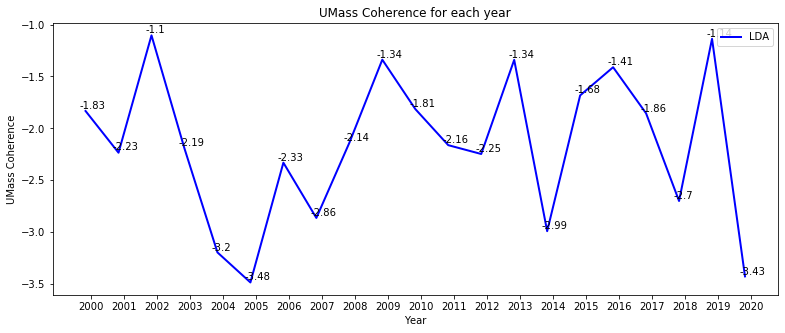

<Figure size 432x288 with 0 Axes>

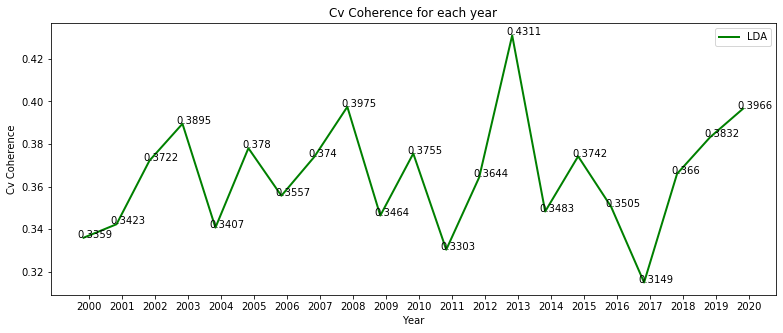

<Figure size 432x288 with 0 Axes>

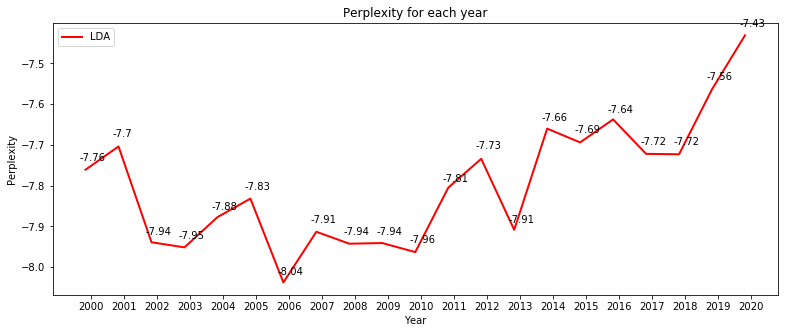

In [4]:
from gensim.models import LdaModel
from gensim.test.utils import datapath
from pathlib import Path

import matplotlib.pyplot as plt


num_topics = 5
no_above = .75
no_below = 2

year_range = range(2000, 2021)
model_dir = str(Path("../data/LDA/final").resolve())
input_dir = str(Path("../data/preprocessed").resolve())
target = str(Path("../data/LDA/final").resolve())

if not os.path.exists(target):
    os.makedirs(target)

coherence_umass = []
coherence_cv = []
perplexity = []

target = str(target)
if not os.path.exists(target):
    os.makedirs(target)

for year in year_range:
    print("Getting coherence & perplexity scores for", year)
    cur_corpus = []
    input_file = Path(input_dir, str(year) + ".pickle")
    with open(input_file, "rb") as file:
        cur_corpus = pickle.load(file)
    
    dictionary = TopicModeler.create_dictionary(cur_corpus, no_below=no_below, no_above=no_above)
    bow_corpus = TopicModeler.create_bow(cur_corpus, dictionary)
    lda_model = LdaModel.load(str(Path(model_dir, str(year) + ".gensim")))
    
    coherence_umass.append(TopicModeler.get_coherence_umass(lda_model, bow_corpus))
    coherence_cv.append(TopicModeler.get_coherence_cv(lda_model, cur_corpus, dictionary))
    perplexity.append(TopicModeler.get_perplexity(lda_model, bow_corpus))

    
# Visualize the results
width = 0.35
xlocs = [i for i in year_range]

## Coherence UMass
plt.clf()
plt.figure(figsize=(13,5))
plt.title("UMass Coherence for each year")
plt.xlabel("Year") 
plt.ylabel("UMass Coherence")

for x, y in enumerate([round(c, 2) for c in coherence_umass]):
    plt.text(xlocs[x] - width/2, y + .02, str(y))
plt.xticks([num + width/2 for num in year_range],
           year_range)

plt.plot(year_range, coherence_umass, color='blue', linewidth=2, label="LDA")
plt.legend(loc="best")
plt.savefig(Path(target,"years-coherence_umass.png"))
plt.show()

## Coherence Cv
plt.clf()
plt.figure(figsize=(13,5))
plt.title("Cv Coherence for each year")
plt.xlabel("Year") 
plt.ylabel("Cv Coherence")

for x, y in enumerate([round(c, 4) for c in coherence_cv]):
    plt.text(xlocs[x] - width/2, y, str(y))
plt.xticks([num + width/2 for num in year_range],
           year_range)

plt.plot(year_range, coherence_cv, color='green', linewidth=2, label="LDA")
plt.legend(loc="best")
plt.savefig(Path(target,"years-coherence_cv.png"))
plt.show()

## Perplexity
plt.clf()
plt.figure(figsize=(13,5))
plt.title("Perplexity for each year")
plt.xlabel("Year") 
plt.ylabel("Perplexity")

for x, y in enumerate([round(p, 2) for p in perplexity]):
    plt.text(xlocs[x] - width/2, y + .02, str(y))
plt.xticks([num + width/2 for num in year_range],
           year_range)

plt.plot(year_range, perplexity, color='red', linewidth=2, label="LDA")
plt.legend(loc="best")
plt.savefig(Path(target, "years-perplexity.png"))
plt.show()

## Extra: Temporal topic divergence

<Figure size 432x288 with 0 Axes>

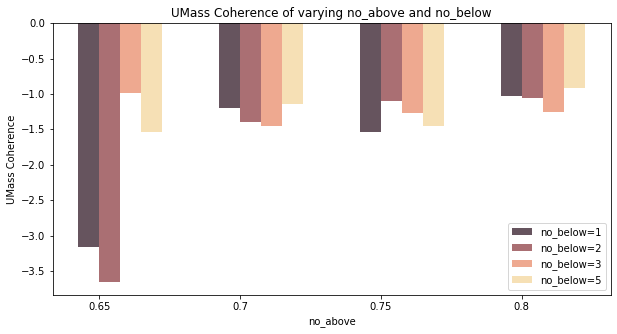

<Figure size 432x288 with 0 Axes>

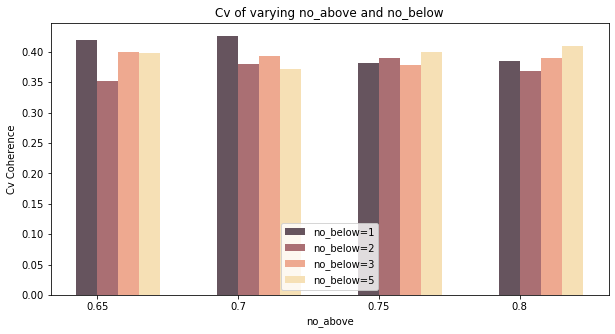

<Figure size 432x288 with 0 Axes>

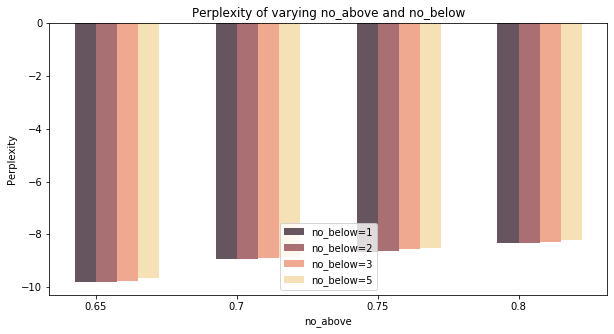

In [15]:
import matplotlib.pyplot as plt

# Visualize the results
width = 0.15
xlocs = range(len(no_above))
colors = [(102,84,94), (170,111,115), (238,169,144), (246,224,181)]
colors = [(r/255,g/255,b/255) for (r,g,b) in colors]

# Visualize the UMass Coherence
plt.clf()
plt.figure(figsize=(10,5))
plt.title("UMass Coherence of varying no_above and no_below")
plt.xlabel("no_above") 
plt.ylabel("UMass Coherence")

for i in xlocs:
    vals = [val[i] for val in coherence_umass]
    plt.bar([j + width*i for j in xlocs], vals, width, label="no_below=" + str(no_below[i]), 
            color = colors[i])
    
plt.xticks([j + width/2 for j in xlocs], no_above)
plt.legend(loc="best")
plt.savefig(Path(target, "umass_nbna.png"))
plt.show()

# Visualize the Cv Coherence
plt.clf()
plt.figure(figsize=(10,5))
plt.title("Cv of varying no_above and no_below")
plt.xlabel("no_above") 
plt.ylabel("Cv Coherence")

for i in xlocs:
    vals = [val[i] for val in coherence_cv]
    plt.bar([j + width*i for j in xlocs], vals, width, label="no_below=" + str(no_below[i]), 
            color = colors[i])
    
plt.xticks([j + width/2 for j in xlocs], no_above)
plt.legend(loc="best")
plt.savefig(Path(target, "cv_nbna.png"))
plt.show()

# Visualize the Perplexity
plt.clf()
plt.figure(figsize=(10,5))
plt.title("Perplexity of varying no_above and no_below")
plt.xlabel("no_above") 
plt.ylabel("Perplexity")

for i in xlocs:
    vals = [val[i] for val in perplexity]
    plt.bar([j + width*i for j in xlocs], vals, width, label="no_below=" + str(no_below[i]), 
            color = colors[i])
    
plt.xticks([j + width/2 for j in xlocs], no_above)
plt.legend(loc="best")
plt.savefig(Path(target, "perplexity_nbna.png"))
plt.show()

## Calculate the similiarity/divergence between papers for each year

<Figure size 432x288 with 0 Axes>

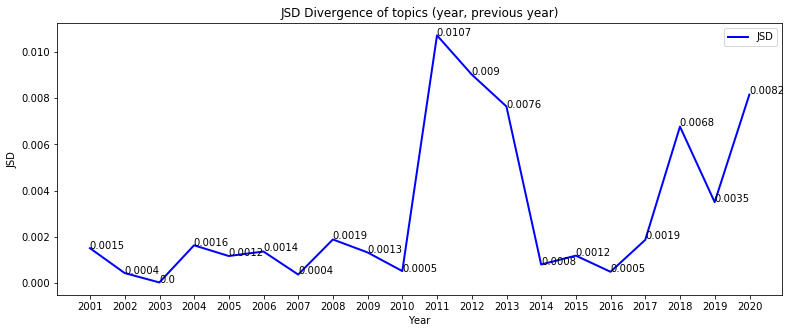

<Figure size 432x288 with 0 Axes>

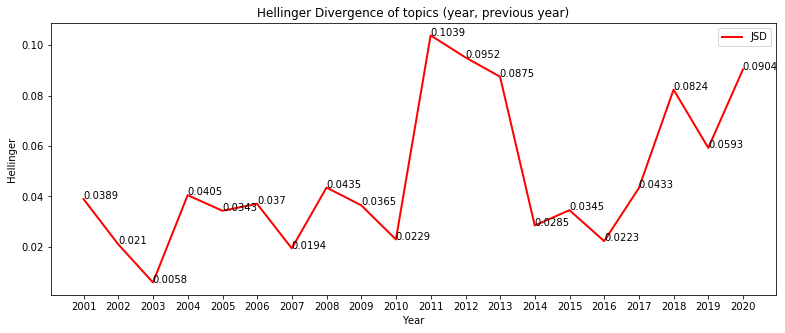

In [17]:
from gensim.matutils import jensen_shannon, hellinger
from gensim.models import LdaModel
from pathlib import Path

import matplotlib.pyplot as plt


year_range = range(2000, 2021)
model_dir = str(Path("../data/LDA/final").resolve())
input_dir = str(Path("../data/preprocessed").resolve())
target = str(Path("../data/LDA/final").resolve())

if not os.path.exists(target):
    os.makedirs(target)

lda_model = LdaModel.load(str(Path(model_dir, "all.gensim")))
distributions = []
divergence_hellinger = []
divergence_jsd = []

for year in year_range:
    cur_corpus = []
    input_file = Path(input_dir, str(year) + ".pickle")
    with open(input_file, "rb") as file:
        cur_corpus = pickle.load(file)
    cur_corpus = [token for sentence in cur_corpus for token in sentence]
    
    dist = [(t, 0) for t in range(1, num_topics+1)]
    for t, p in lda_model[lda_model.id2word.doc2bow(cur_corpus)]:
        dist[t] = (t, p)     
    distributions.append(dist)

# Divergence (year, previous year)
for i in range(1, len(year_range)):
    divergence_hellinger.append(hellinger(distributions[i], distributions[i-1]))
    divergence_jsd.append(jensen_shannon(distributions[i], distributions[i-1]))

# JSD Divergence
width = 0.01
xlocs = [i for i in year_range[1:]]

plt.clf()
plt.figure(figsize=(13,5))
plt.title("JSD Divergence of topics (year, previous year)")
plt.xlabel("Year") 
plt.ylabel("JSD")

for x, y in enumerate([round(c, 4) for c in divergence_jsd]):
    plt.text(xlocs[x] - width/2, y, str(y))
plt.xticks([num + width/2 for num in year_range[1:]],
           year_range[1:])

plt.plot(year_range[1:], divergence_jsd, color='blue', linewidth=2, label="JSD")
plt.legend(loc="best")
plt.savefig(Path(target,"divergence_jsd.png"))
plt.show()

# Hellinger divergence
plt.clf()
plt.figure(figsize=(13,5))
plt.title("Hellinger Divergence of topics (year, previous year)")
plt.xlabel("Year") 
plt.ylabel("Hellinger")

for x, y in enumerate([round(c, 4) for c in divergence_hellinger]):
    plt.text(xlocs[x] - width/2, y, str(y))
plt.xticks([num + width/2 for num in year_range[1:]],
           year_range[1:])

plt.plot(year_range[1:], divergence_hellinger, color='red', linewidth=2, label="JSD")
plt.legend(loc="best")
plt.savefig(Path(target,"divergence_hellinger.png"))
plt.show()

## Calculate the divergence between papers for from a year to previous years

<Figure size 432x288 with 0 Axes>

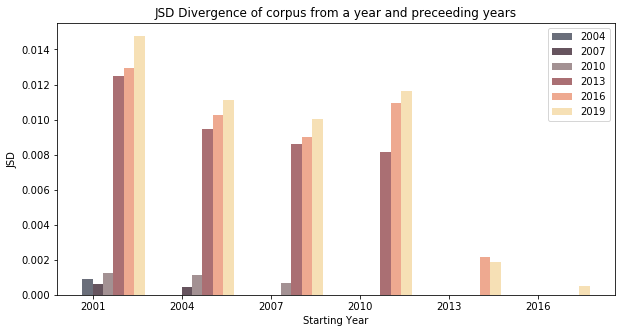

<Figure size 432x288 with 0 Axes>

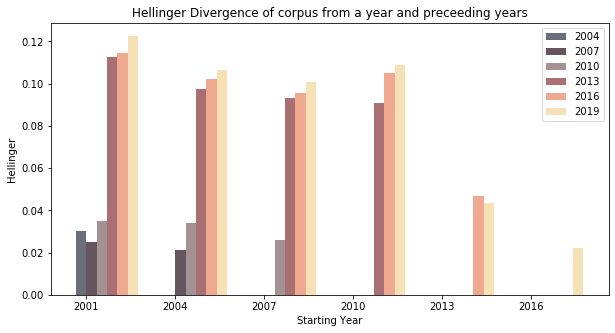

In [18]:
from gensim.matutils import jensen_shannon, hellinger
from gensim.models import LdaModel
from pathlib import Path

import matplotlib.pyplot as plt
import random


year_range = range(2001, 2021, 3)
model_dir = str(Path("../data/LDA/final").resolve())
input_dir = str(Path("../data/preprocessed").resolve())
target = str(Path("../data/LDA/final").resolve())

if not os.path.exists(target):
    os.makedirs(target)

lda_model = LdaModel.load(str(Path(model_dir, "all.gensim")))
distributions = []
colors = [(106,110,122), (102,84,94), (163,145,147), (170,111,115), (238,169,144), (246,224,181)]
colors = [(r/255,g/255,b/255) for (r,g,b) in colors]
divergence_hellinger = []
divergence_jsd = []

for year in year_range:
    cur_corpus = []
    input_file = Path(input_dir, str(year) + ".pickle")
    with open(input_file, "rb") as file:
        cur_corpus = pickle.load(file)
    cur_corpus = [token for sentence in cur_corpus for token in sentence]
    
    dist = [(t, 0) for t in range(1, num_topics+1)]
    for t, p in lda_model[lda_model.id2word.doc2bow(cur_corpus)]:
        dist[t] = (t, p)     
    distributions.append(dist)

# Divergence (year, previous year)
for i in range(0, len(year_range)-1):
    cur_div_hell = []
    cur_div_jsd = []
    for j in range(1, len(year_range)):
        if (i < j):
            cur_div_hell.append(hellinger(distributions[j], distributions[i]))
            cur_div_jsd.append(jensen_shannon(distributions[j], distributions[i]))
        else:
            cur_div_jsd.append(0)
            cur_div_hell.append(0)
    divergence_hellinger.append(cur_div_hell)
    divergence_jsd.append(cur_div_jsd)


# Print the JSD for a year and preceeding years
plt.clf()
plt.figure(figsize=(10,5))
plt.title("JSD Divergence of corpus from a year and preceeding years")
plt.xlabel("Starting Year") 
plt.ylabel("JSD")

width = 0.35
xlocs = [i for i in year_range[:-1]]
for i in range(0, len(year_range)-1):
    vals = [div[i] for div in divergence_jsd]
    plt.bar([year + width*i for year in year_range[:-1]], vals, width, label=str(year_range[i+1]), 
            color = colors[i])
    
plt.xticks([year + width/2 for year in year_range[:-1]], year_range[:-1])
plt.legend(loc="best")
plt.savefig(Path(target, "jsd_preceeding_years.png"))
plt.show()

# Print the hellinger for a year and preceeding years
plt.clf()
plt.figure(figsize=(10,5))
plt.title("Hellinger Divergence of corpus from a year and preceeding years")
plt.xlabel("Starting Year") 
plt.ylabel("Hellinger")

width = 0.35
xlocs = [i for i in year_range[:-1]]
for i in range(0, len(year_range)-1):
    vals = [div[i] for div in divergence_hellinger]
    plt.bar([year + width*i for year in year_range[:-1]], vals, width, label=str(year_range[i+1]), 
            color = colors[i])
    
plt.xticks([year + width/2 for year in year_range[:-1]], year_range[:-1])
plt.legend(loc="best")
plt.savefig(Path(target, "hellinger_preceeding_years.png"))
plt.show()